## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib
matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

out_dir='output_images/stage0/'
images = glob.glob('./camera_cal/calibration*.jpg')

In [2]:
objpoints = [] # Real world space points
imgpoints = [] # Image plane points

for ny in [5,6]:
    for nx in [6,7,8,9]:

        # Initialize object points
        objp = np.zeros((ny*nx,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)


        # For each image look for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)


                # Draw and display the corners
                cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                image_name=os.path.split(fname)[1]
                write_name = out_dir+'corners_ny'+str(ny)+'_nx'+str(nx)+'_'+image_name
                cv2.imwrite(write_name, img)
                print(fname)
                cv2.imshow('img', img)
                cv2.waitKey(500)
    cv2.destroyAllWindows()

../camera_cal/calibration15.jpg
../camera_cal/calibration4.jpg
../camera_cal/calibration5.jpg
../camera_cal/calibration1.jpg
../camera_cal/calibration15.jpg
../camera_cal/calibration5.jpg
../camera_cal/calibration14.jpg
../camera_cal/calibration2.jpg
../camera_cal/calibration10.jpg
../camera_cal/calibration11.jpg
../camera_cal/calibration12.jpg
../camera_cal/calibration13.jpg
../camera_cal/calibration14.jpg
../camera_cal/calibration15.jpg
../camera_cal/calibration16.jpg
../camera_cal/calibration17.jpg
../camera_cal/calibration18.jpg
../camera_cal/calibration19.jpg
../camera_cal/calibration2.jpg
../camera_cal/calibration20.jpg
../camera_cal/calibration3.jpg
../camera_cal/calibration6.jpg
../camera_cal/calibration7.jpg
../camera_cal/calibration8.jpg
../camera_cal/calibration9.jpg


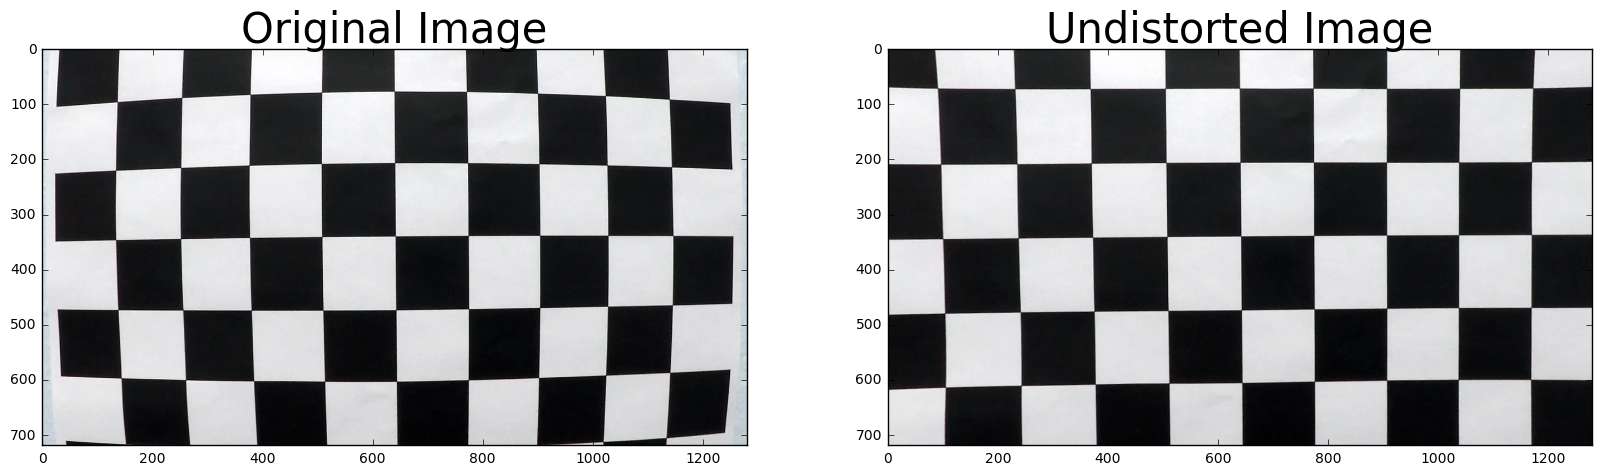

In [3]:
# Image undistortion sample
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Calibrate camera with the given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# Undistort image with the undistortion matrix
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
# Save the camera calibration data
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )

In [5]:

# load pickled distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

# Undistort and visualize test images
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = out_dir+'undistorted_'+image_name
    cv2.imwrite(write_name,dst)
    print(write_name)
    cv2.imshow('dst', dst)
    cv2.waitKey(500)
cv2.destroyAllWindows()

output_images/stage0/undistorted_calibration1.jpg
output_images/stage0/undistorted_calibration10.jpg
output_images/stage0/undistorted_calibration11.jpg
output_images/stage0/undistorted_calibration12.jpg
output_images/stage0/undistorted_calibration13.jpg
output_images/stage0/undistorted_calibration14.jpg
output_images/stage0/undistorted_calibration15.jpg
output_images/stage0/undistorted_calibration16.jpg
output_images/stage0/undistorted_calibration17.jpg
output_images/stage0/undistorted_calibration18.jpg
output_images/stage0/undistorted_calibration19.jpg
output_images/stage0/undistorted_calibration2.jpg
output_images/stage0/undistorted_calibration20.jpg
output_images/stage0/undistorted_calibration3.jpg
output_images/stage0/undistorted_calibration4.jpg
output_images/stage0/undistorted_calibration5.jpg
output_images/stage0/undistorted_calibration6.jpg
output_images/stage0/undistorted_calibration7.jpg
output_images/stage0/undistorted_calibration8.jpg
output_images/stage0/undistorted_calibr

## Image pipeline

In [6]:
import os
import scipy
from scipy import signal
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from collections import deque
import glob
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

out_dir='./output_images/stage1/'

# load pickled distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

In [7]:
# Test images
images = glob.glob('./test_images/*.jpg')

# Visualize undistorted test images
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = out_dir+'undistorted_'+image_name
    cv2.imwrite(write_name,dst)
    print(write_name)
    cv2.imshow('dst', dst)
cv2.destroyAllWindows()

output_images/stage1/undistorted_straight_lines1.jpg
output_images/stage1/undistorted_straight_lines2.jpg
output_images/stage1/undistorted_test1.jpg
output_images/stage1/undistorted_test2.jpg
output_images/stage1/undistorted_test3.jpg
output_images/stage1/undistorted_test4.jpg
output_images/stage1/undistorted_test5.jpg
output_images/stage1/undistorted_test6.jpg


In [9]:
S_TRESHOLD_LOW = 120
S_TRESHOLD_HIGH = 255

SX_TRESHOLD_LOW = 20
SX_TRESHOLD_HIGH = 255

L_TRESHOLD_LOW = 40
L_TRESHOLD_HIGH = 255

# Undistort image
def undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

# Return binary and channels of image
def binarize(img, s_thresh=(S_TRESHOLD_LOW, S_TRESHOLD_HIGH), sx_thresh=(SX_TRESHOLD_LOW, S_TRESHOLD_HIGH),
             l_thresh=(L_TRESHOLD_LOW,L_TRESHOLD_HIGH)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary,channels

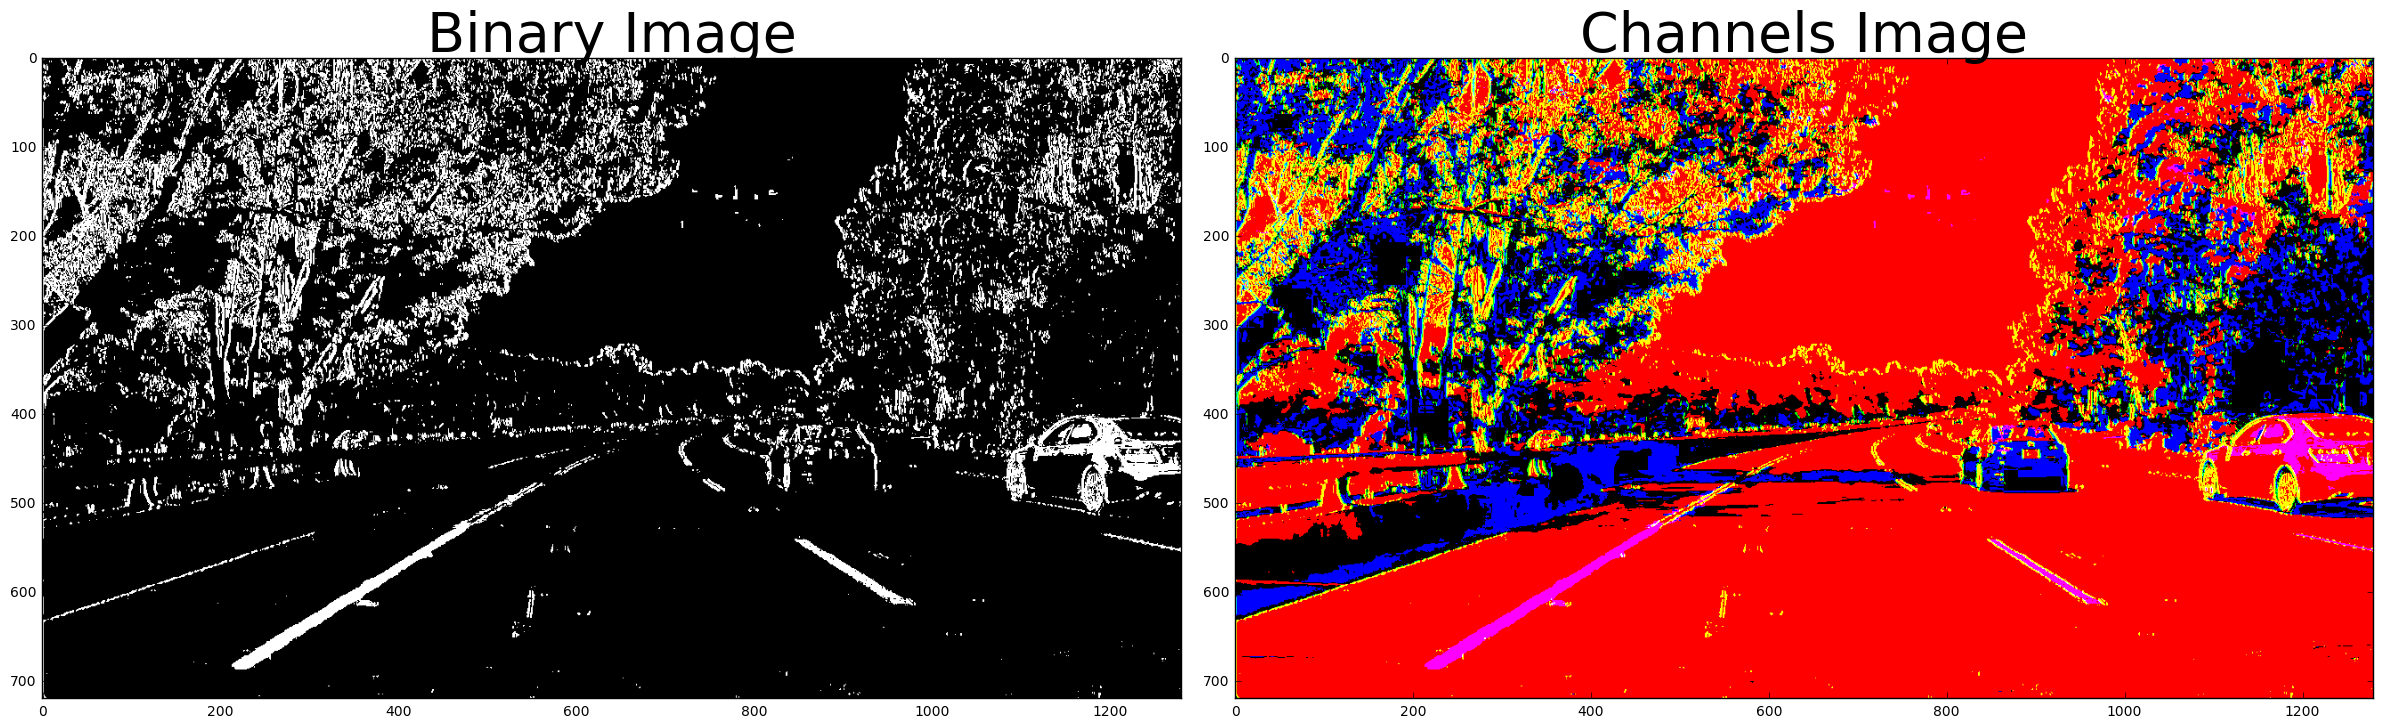

In [11]:
img = plt.imread('./test_images/test5.jpg')

shape = img.shape
binary,channels = binarize(img)
plt.imsave(out_dir+'binary.jpg',binary)
plt.imsave(out_dir+'channels.jpg',channels)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary)
ax1.set_title('Binary Image', fontsize=40)

ax2.imshow(channels)
ax2.set_title('Channels Image', fontsize=40)

In [12]:
# Warp image
def warp(img,tobird=True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

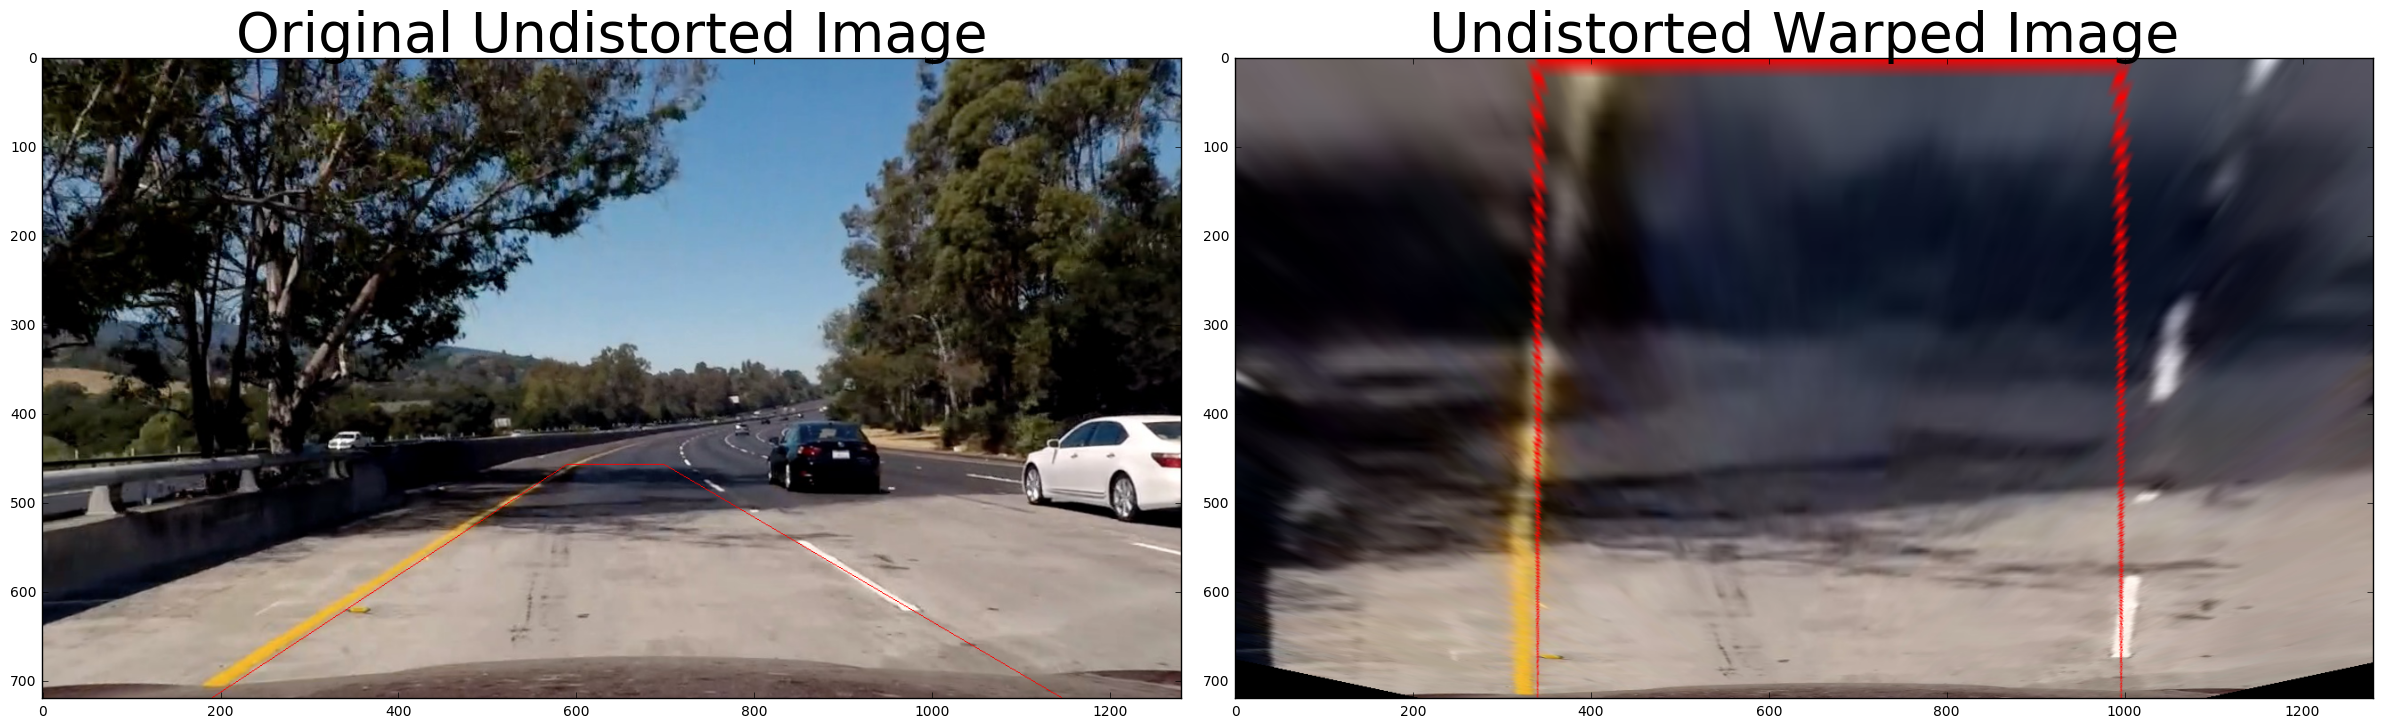

In [14]:
img=plt.imread('./test_images/test5.jpg')
corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])

# undistort
img = cv2.undistort(img, mtx, dist, None, mtx)
imshape = img.shape

corner_tuples=[]
for ind,c in enumerate(corners):
    corner_tuples.append(tuple(corners[ind]))

cv2.line(img, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=1)

warped,_ = warp(img) 
plt.imsave(out_dir+'straight_red.jpg',img)
plt.imsave(out_dir+'straight_red_warped.jpg',warped)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Undistorted Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Undistorted Warped Image', fontsize=40)

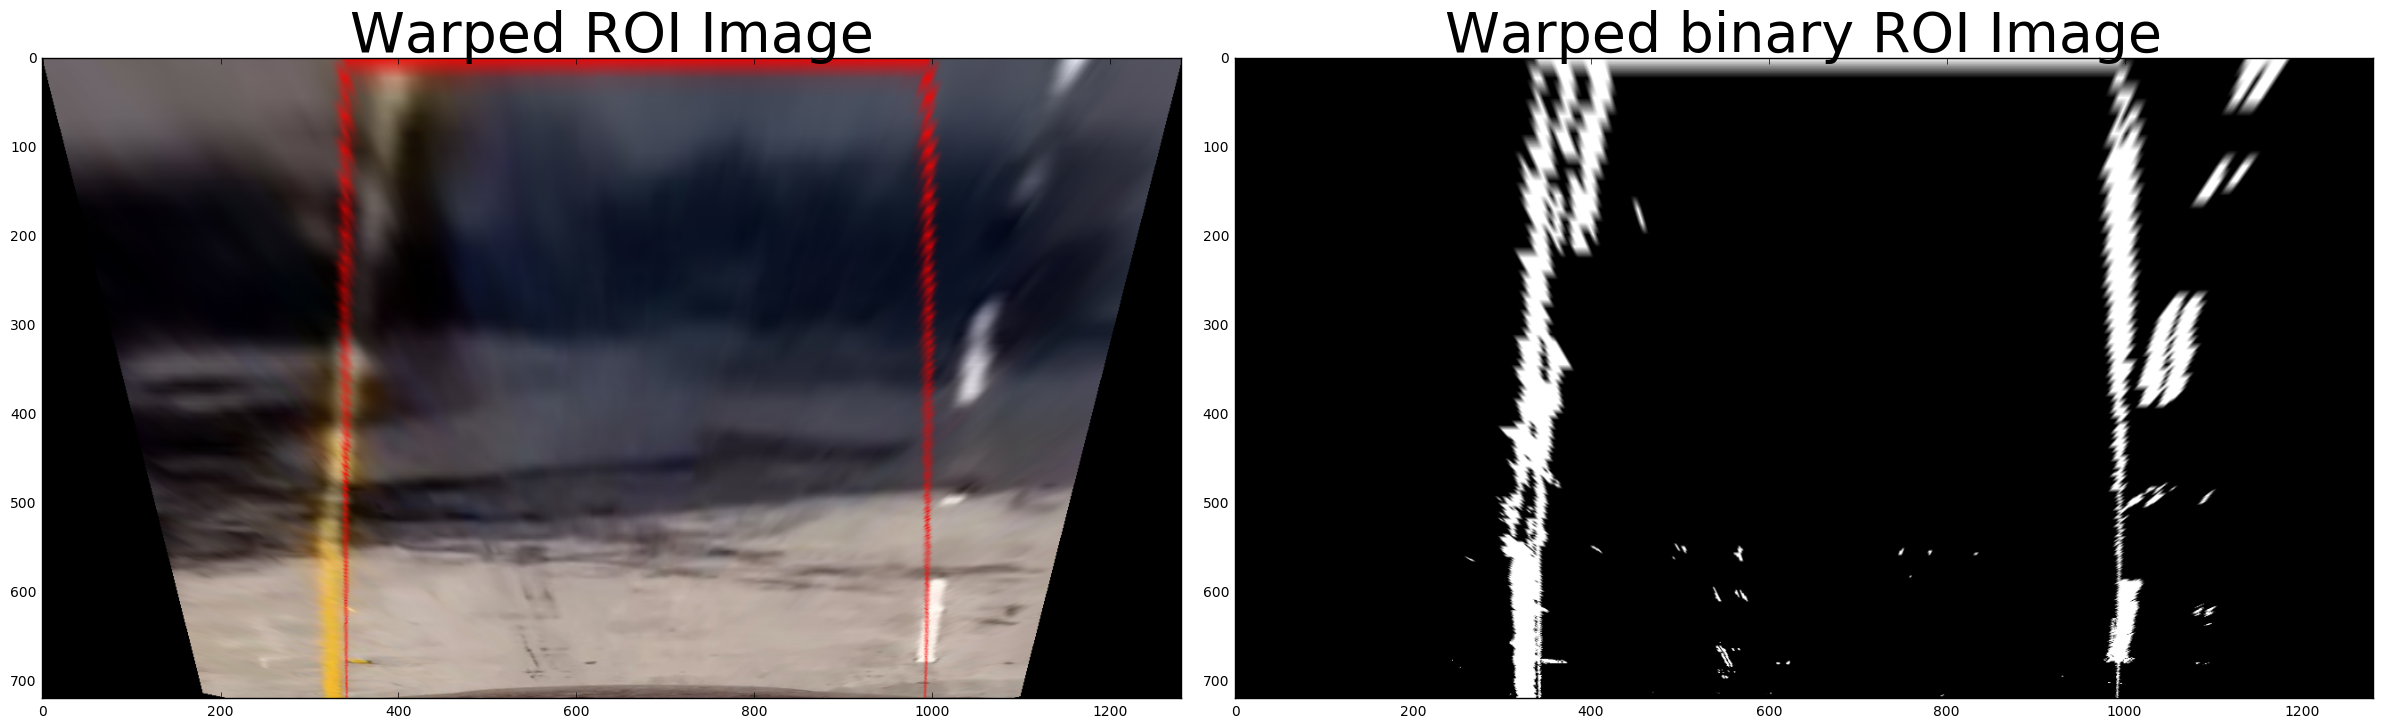

In [15]:
# Apply a mask to the image to consider only the area of interest

def region_of_interest(img):
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def warp_pipeline(img):
    undist = undistort(img)    
    result,_ = warp(undist)
    result = region_of_interest(result)
    return result
    
def warp_binarize_pipeline(img):
    undist = undistort(img)
    binary,_  = binarize(undist)
    result,_  = warp(binary)
    result = region_of_interest(result)
    return result 

warp_roi = warp_pipeline(img)
warp_binary_roi = warp_binarize_pipeline(img)

plt.imsave(out_dir+'warp_roi.jpg',warp_roi)
plt.imsave(out_dir+'warp_binary_roi.jpg',warp_binary_roi)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warp_roi)
ax1.set_title('Warped ROI Image', fontsize=40)

ax2.imshow(warp_binary_roi)
ax2.set_title('Warped binary ROI Image', fontsize=40)

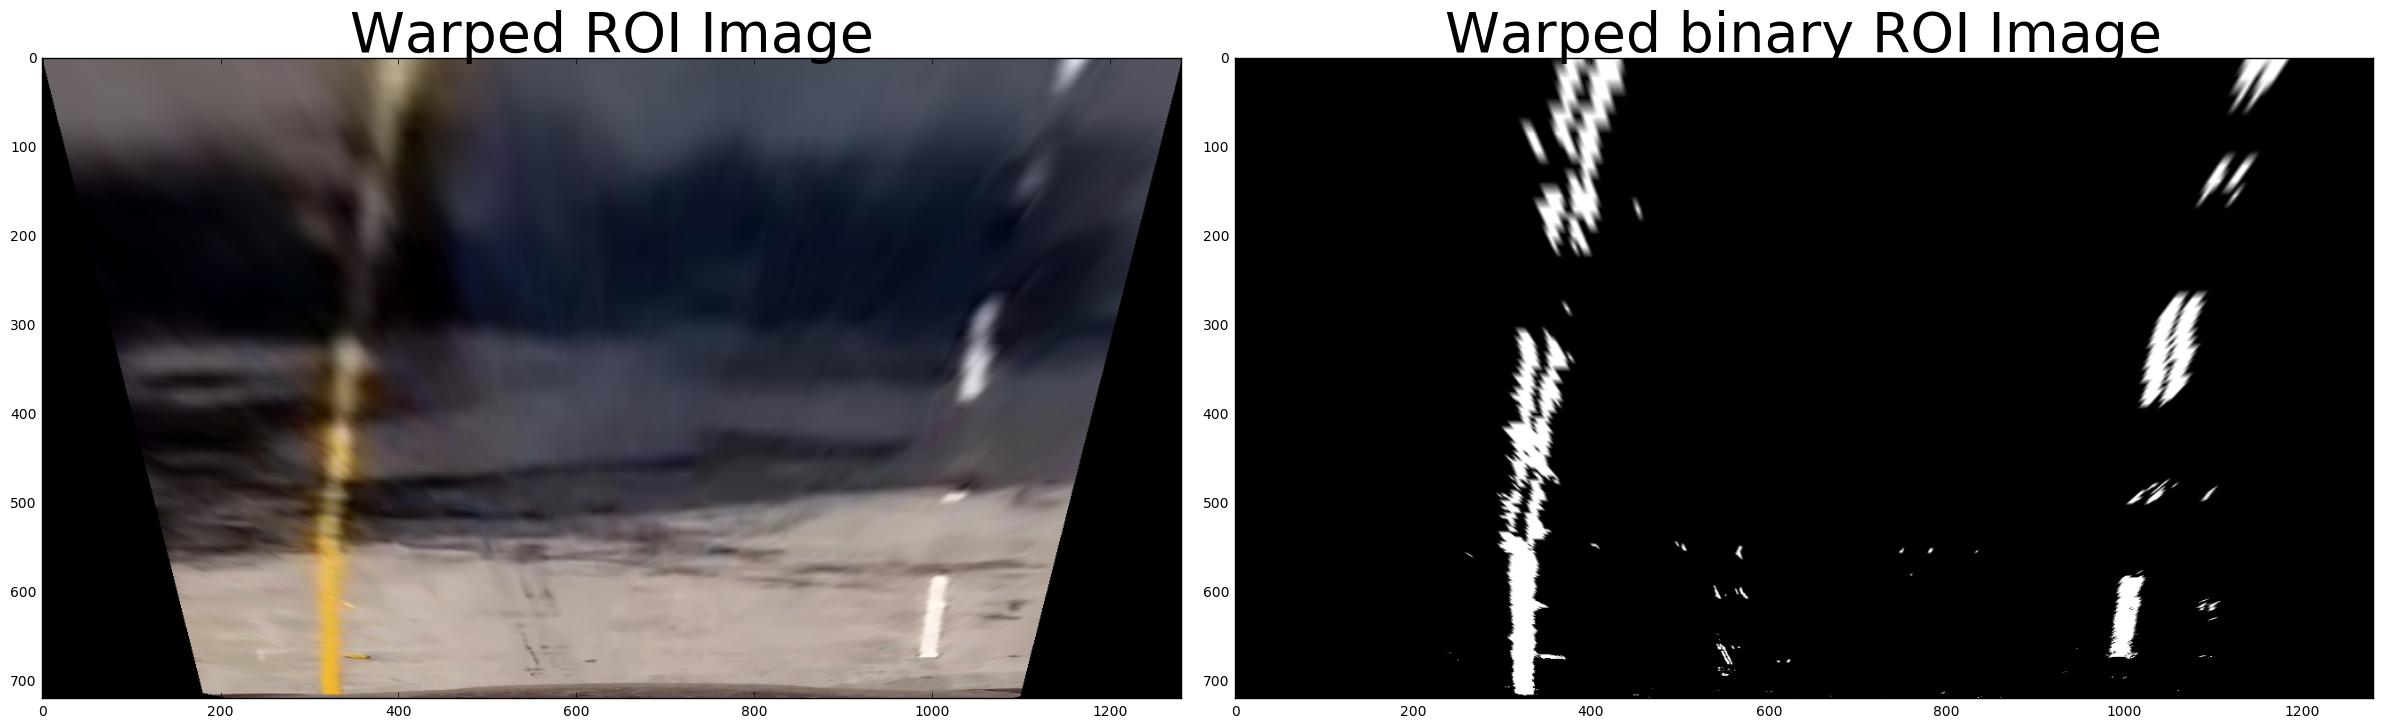

In [17]:
# now back to the test image
img=plt.imread('./test_images/test5.jpg')
warped = warp_pipeline(img)
warped_binary = warp_binarize_pipeline(img)

plt.imsave(out_dir+'warp_test5.jpg',warped)
plt.imsave(out_dir+'warp_binary_test5.jpg',warped_binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Warped ROI Image', fontsize=40)

ax2.imshow(warped_binary)
ax2.set_title('Warped binary ROI Image', fontsize=40)

In [18]:
def get_peaks(img,thresh):
    img_half=img[img.shape[0]/2:,:,0]
    data = np.sum(img_half, axis=0)
    filtered = scipy.ndimage.filters.gaussian_filter1d(data,20)
    xs = np.arange(len(filtered))
    peak_ind = signal.find_peaks_cwt(filtered, np.arange(20,300))
    peaks = np.array(peak_ind)
    peaks = peaks[filtered[peak_ind]>thresh]
    return peaks,filtered


def get_next_window(img,center_point,width):
    ny,nx,_ = img.shape
    mask  = np.zeros_like(img)
    if (center_point <= width/2): center_point = width/2
    if (center_point >= nx-width/2): center_point = nx-width/2
    
    left  = center_point - width/2
    right = center_point + width/2
    
    vertices = np.array([[(left,0),(left,ny), (right,ny),(right,0)]], dtype=np.int32)
    ignore_mask_color=(255,255,255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(mask,img)

    hist = np.sum(masked[:,:,0],axis=0)
    if max(hist>10000):
        center = np.argmax(hist)
    else:
        center = center_point
        
    return masked,center

def get_lane_from_window(binary,center_point,width):
    n_zones=6
    ny,nx,nc = binary.shape
    zones = binary.reshape(n_zones,-1,nx,nc)
    zones = zones[::-1] # start from the bottom slice
    window,center = get_next_window(zones[0],center_point,width)
    
    for zone in zones[1:]:
        next_window,center = get_next_window(zone,center,width)
        window = np.vstack((next_window,window))
    
    return window

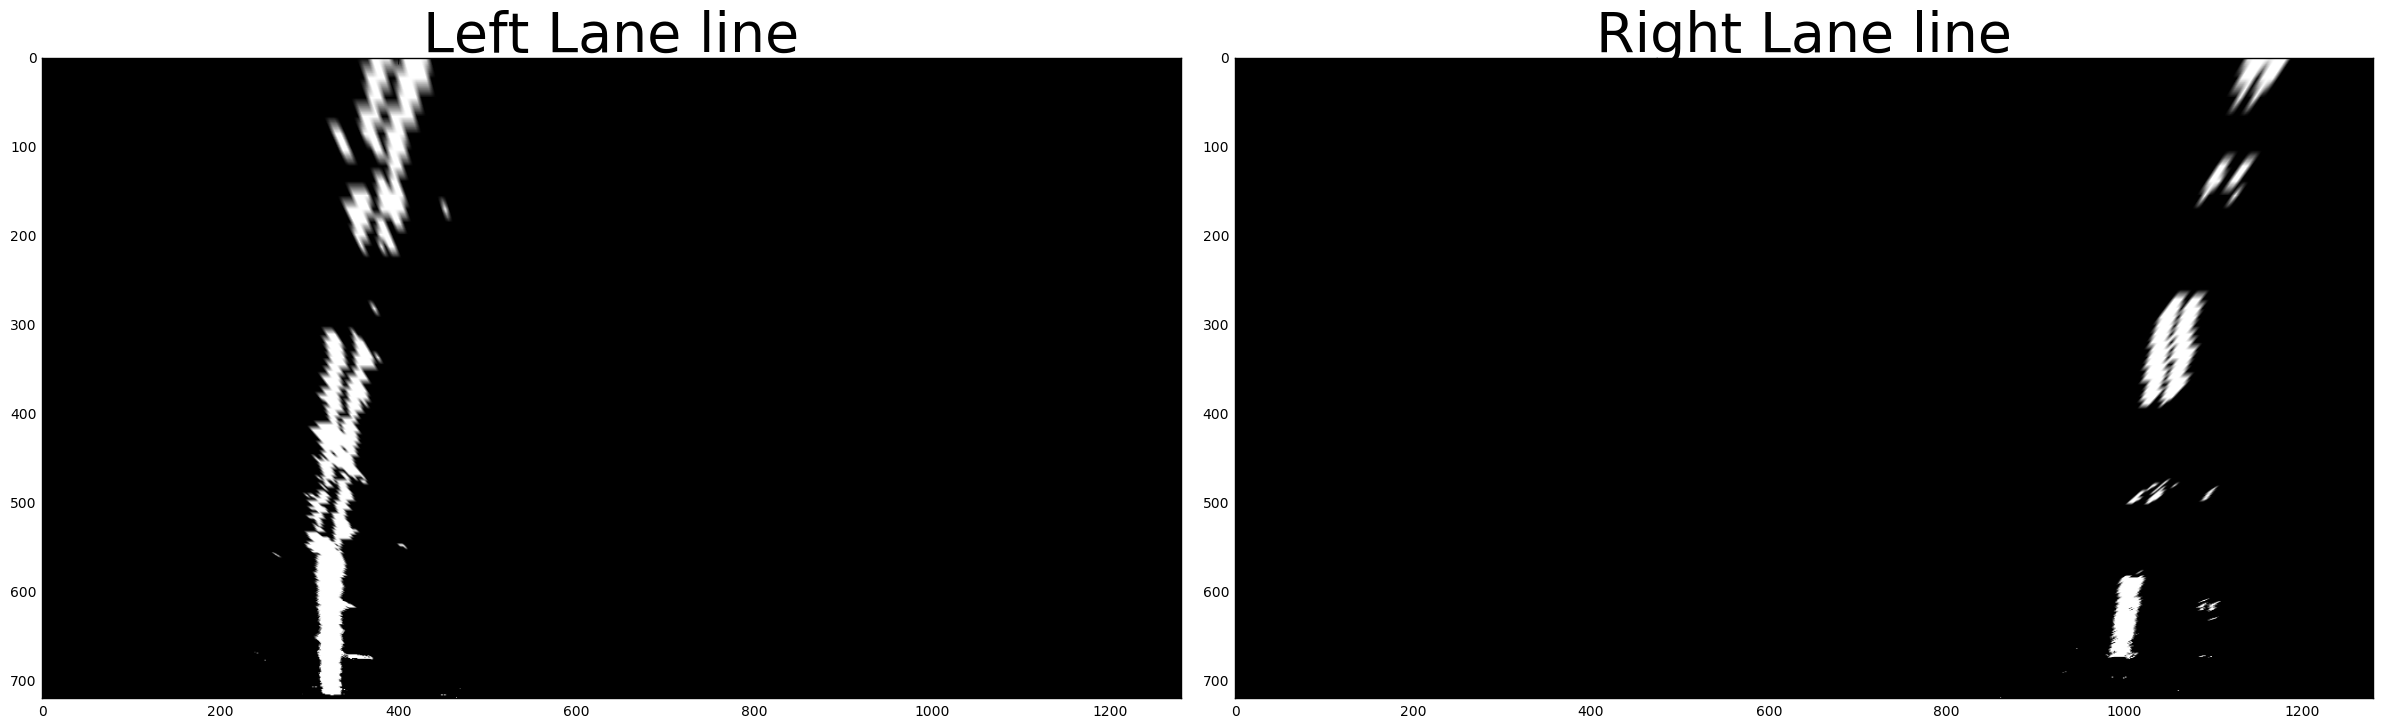

In [20]:
left_binary = get_lane_from_window(warped_binary,380,300)
right_binary = get_lane_from_window(warped_binary,1000,300)

plt.imsave(out_dir+'left_line.jpg',left_binary)
plt.imsave(out_dir+'right_line.jpg',right_binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(left_binary)
ax1.set_title('Left Lane line', fontsize=40)

ax2.imshow(right_binary)
ax2.set_title('Right Lane line', fontsize=40)

In [21]:
# Line class to store the feature of each line detection
class Line:
    def __init__(self,n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=n)
        #average x values of the fitted line over the last n iterations
        self.avgx = None
        # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit_coeffs = None  
        # xvals of the most recent fit
        self.current_fit_xvals = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = [np.array([False])]          
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for line fit
        self.fit_yvals = np.linspace(0, 100, num=101)*7.2  # always the same y-range as image
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # origin (pixels) of fitted line at the bottom of the image
        self.line_pos = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

    def set_current_fit_xvals(self):
        yvals = self.fit_yvals
        self.current_fit_xvals = self.current_fit_coeffs[0]*yvals**2 + self.current_fit_coeffs[1]*yvals + self.current_fit_coeffs[2]
        
    def add_data(self):
        self.recent_xfitted.appendleft(self.current_fit_xvals)
        self.recent_fit_coeffs.appendleft(self.current_fit_coeffs)
        assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
        self.n_buffered = len(self.recent_xfitted)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_xfitted.pop()
            self.recent_fit_coeffs.pop()
            assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
            self.n_buffered = len(self.recent_xfitted)
        
        return self.n_buffered
        
    def set_avgx(self):
        fits = self.recent_xfitted
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.avgx = avg
            
    def set_avgcoeffs(self):
        coeffs = self.recent_fit_coeffs
        if len(coeffs)>0:
            avg=0
            for coeff in coeffs:
                avg +=np.array(coeff)
            avg = avg / len(coeffs)
            self.avg_fit_coeffs = avg
    
    def set_allxy(self,lane_candidate):
        self.ally,self.allx = (lane_candidate[:,:,0]>254).nonzero()

    def set_current_fit_coeffs(self):
        self.current_fit_coeffs = np.polyfit(self.ally, self.allx, 2)
    
    def get_diffs(self):
        if self.n_buffered>0:
            self.diffs = self.current_fit_coeffs - self.avg_fit_coeffs
        else:
            self.diffs = np.array([0,0,0], dtype='float')                 
            
    def set_radius_of_curvature(self):
        # Define y-value where we want radius of curvature (choose bottom of the image)
        y_eval = max(self.fit_yvals)
        if self.avg_fit_coeffs is not None:
            self.radius_of_curvature = ((1 + (2*self.avg_fit_coeffs[0]*y_eval + self.avg_fit_coeffs[1])**2)**1.5) \
                             /np.absolute(2*self.avg_fit_coeffs[0])
                        
            
    def set_line_base_pos(self):
        y_eval = max(self.fit_yvals)
        self.line_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        +self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        basepos = 640
        
        self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction

    # here come sanity checks of the computed metrics
    def accept_lane(self):
        flag = True
        maxdist = 2.8  # distance in meters from the lane
        if(abs(self.line_base_pos) > maxdist ):
            print('lane too far away')
            flag  = False        
        if(self.n_buffered > 0):
            relative_delta = self.diffs / self.avg_fit_coeffs
            # allow maximally this percentage of variation in the fit coefficients from frame to frame
            if not (abs(relative_delta)<np.array([0.7,0.5,0.15])).all():
                print('fit coeffs too far off [%]',relative_delta)
                flag=False
                
        return flag
    
    def update(self,lane):
        self.set_allxy(lane)
        self.set_current_fit_coeffs()
        self.set_current_fit_xvals()
        self.set_radius_of_curvature()
        self.set_line_base_pos()
        self.get_diffs()
        if self.accept_lane():
            self.detected=True
            self.add_data()
            self.set_avgx()
            self.set_avgcoeffs()            
        else:
            self.detected=False            
            self.pop_data()
            if self.n_buffered>0:
                self.set_avgx()
                self.set_avgcoeffs()
                    
        return self.detected,self.n_buffered
    
def get_binary_lane_image(img,line,window_center,width=300):
    if line.detected:
        window_center=line.line_pos
    else:
        peaks,filtered = get_peaks(img,thresh=3000)
        if len(peaks)!=2:
            print('Trouble ahead! '+ str(len(peaks)) +' lanes detected!')
            plt.imsave('troublesome_image.jpg',img)                        
            
        peak_ind = np.argmin(abs(peaks-window_center))
        peak  = peaks[peak_ind]
        window_center = peak
    
    lane_binary = get_lane_from_window(img,window_center,width)
    return lane_binary

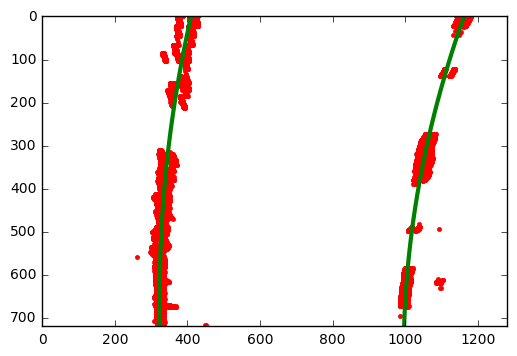

In [22]:
left=Line()
right=Line()

detected_l,n_buffered_left = left.update(left_binary)
detected_r,n_buffered_right = right.update(right_binary)

leftx = left.allx
left_fitx = left.current_fit_xvals
yvals_l = left.ally

rightx = right.allx
right_fitx = right.current_fit_xvals
yvals_r = right.ally

yvals = left.fit_yvals

plt.plot(rightx, yvals_r, '.', color='red')
plt.plot(right_fitx, yvals, color='green', linewidth=3)

plt.plot(leftx, yvals_l, '.', color='red')
plt.plot(left_fitx, yvals, color='green', linewidth=3)

plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.gca().invert_yaxis()
plt.savefig(out_dir+'fitted_lines.jpg')
plt.show()

In [23]:
def project_lane_lines(img,left_fitx,right_fitx,yvals):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    undist = undistort(img)    
    unwarp,Minv = warp(img,tobird=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [31]:
def analyze_for_lane(img):
    global left
    global right
    undist = undistort(img)
    binary,_  = binarize(undist)
    warped,_  = warp(binary)
    warped_binary = region_of_interest(warped)
    
    window_center_l = 340
    if left.detected:
        window_center_l = left.line_pos        
    left_binary = get_binary_lane_image(warped_binary,left,window_center_l,width=300)
    
    window_center_r = 940
    if right.detected:
        window_center_r = right.line_pos        
    right_binary = get_binary_lane_image(warped_binary,right,window_center_r,width=300)
    
    detected_l,n_buffered_left = left.update(left_binary)
    detected_r,n_buffered_right = right.update(right_binary)    
    
    left_fitx = left.avgx
    right_fitx = right.avgx
    yvals = left.fit_yvals
    lane_width = 3.7
    off_center = -100*round(0.5*(right.line_base_pos-lane_width/2) +  0.5*(abs(left.line_base_pos)-lane_width/2),2)
    
    result = project_lane_lines(img,left_fitx,right_fitx,yvals)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = str('Distance from center: '+str(off_center)+'cm')
    cv2.putText(result,str1,(430,630), font, 1,(0,0,255),2,cv2.LINE_AA)
    if left.radius_of_curvature and right.radius_of_curvature:
        curvature = 0.5*(round(right.radius_of_curvature/1000,1) + round(left.radius_of_curvature/1000,1))
        str2 = str('radius of curvature: '+str(curvature)+'km')
        cv2.putText(result,str2,(430,670), font, 1,(0,0,255),2,cv2.LINE_AA)    
    
    return result

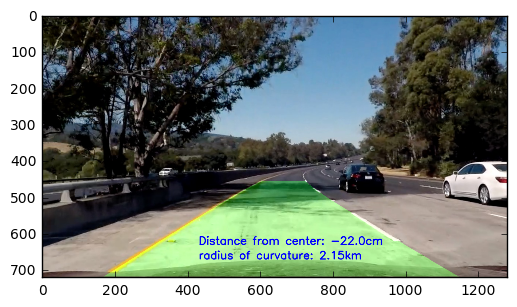

In [37]:
img = plt.imread('./test_images/test5.jpg')
left = Line(7)
right = Line(7)

result = analyze_for_lane(img)
result = analyze_for_lane(img)

plt.figure()
plt.imshow(result)
plt.show()
plt.imsave(out_dir+'project_test5.jpg',result)

## VIDEO pipeline

In [38]:
left = Line(7)
right = Line(7)

out_dir='./'
output = out_dir+'rome_processed_project_video.mp4'
clip = VideoFileClip("./project_video.mp4")
out_clip = clip.fl_image(analyze_for_lane) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./rome_processed_project_video.mp4
[MoviePy] Writing video ./rome_processed_project_video.mp4


  1%|          | 14/1261 [00:04<06:20,  3.28it/s]

fit coeffs too far off [%] [ 1.1555909   0.3657685  -0.01984123]


  1%|          | 15/1261 [00:04<07:32,  2.76it/s]

fit coeffs too far off [%] [ 0.9593654   0.36395055 -0.03662408]


  1%|▏         | 16/1261 [00:05<08:20,  2.49it/s]

fit coeffs too far off [%] [ 0.90042687  0.37676968 -0.04999387]


  1%|▏         | 17/1261 [00:05<08:46,  2.36it/s]

fit coeffs too far off [%] [ 0.73769242  0.34741314 -0.05171969]


  1%|▏         | 18/1261 [00:06<10:23,  1.99it/s]

fit coeffs too far off [%] [ 0.88783465  0.42820984 -0.06149738]


  2%|▏         | 19/1261 [00:07<11:51,  1.74it/s]

fit coeffs too far off [%] [ 1.14822369  0.46549653 -0.05692699]


  2%|▏         | 20/1261 [00:07<11:06,  1.86it/s]

fit coeffs too far off [%] [ 1.62162885  0.47836453 -0.04768783]


  6%|▌         | 74/1261 [00:25<06:09,  3.21it/s]

fit coeffs too far off [%] [ 0.78641221  0.26394027 -0.01138061]


  7%|▋         | 84/1261 [00:28<06:06,  3.21it/s]

fit coeffs too far off [%] [-0.91365891 -0.46128217  0.04282034]


  9%|▉         | 114/1261 [00:41<08:52,  2.15it/s]

fit coeffs too far off [%] [ 0.93758086  0.51816532 -0.03006854]


 12%|█▏        | 148/1261 [00:53<06:20,  2.92it/s]

fit coeffs too far off [%] [ 0.93983001  0.43358786 -0.0423442 ]


 12%|█▏        | 149/1261 [00:53<07:28,  2.48it/s]

fit coeffs too far off [%] [ 0.99705726  0.46536423 -0.04384693]


 12%|█▏        | 150/1261 [00:54<08:25,  2.20it/s]

fit coeffs too far off [%] [ 0.73582954  0.32237227 -0.02576321]


 14%|█▎        | 171/1261 [01:03<06:27,  2.81it/s]

fit coeffs too far off [%] [ 0.77912321  0.19657026  0.00616935]


 14%|█▎        | 172/1261 [01:03<07:14,  2.51it/s]

fit coeffs too far off [%] [ 1.13593836  0.33390925 -0.0034329 ]


 14%|█▎        | 173/1261 [01:04<07:52,  2.30it/s]

fit coeffs too far off [%] [ 1.20424049  0.42416991 -0.02143803]


 14%|█▍        | 174/1261 [01:04<08:05,  2.24it/s]

fit coeffs too far off [%] [ 1.74332135  0.74716085 -0.0640123 ]


 14%|█▍        | 175/1261 [01:04<08:10,  2.21it/s]

fit coeffs too far off [%] [ 1.7071501   0.82287938 -0.08239259]


 14%|█▍        | 176/1261 [01:05<08:14,  2.19it/s]

fit coeffs too far off [%] [ 1.646177    0.86150027 -0.09148067]


 14%|█▍        | 177/1261 [01:05<08:23,  2.15it/s]

fit coeffs too far off [%] [ 1.23048207  0.65476585 -0.06644639]


 24%|██▍       | 305/1261 [01:53<05:02,  3.16it/s]

fit coeffs too far off [%] [-1.6349008  -0.71356205  0.03065478]


 24%|██▍       | 306/1261 [01:54<05:54,  2.69it/s]

fit coeffs too far off [%] [-1.15015693 -0.43714385  0.00776874]


 24%|██▍       | 307/1261 [01:54<06:24,  2.48it/s]

fit coeffs too far off [%] [-1.17760009 -0.53593894  0.02179108]


 25%|██▍       | 311/1261 [01:56<06:30,  2.43it/s]

fit coeffs too far off [%] [-0.80119108 -0.29569872  0.00341297]


 25%|██▍       | 312/1261 [01:57<07:44,  2.04it/s]

fit coeffs too far off [%] [-0.79879687 -0.32586108  0.00678687]


 25%|██▍       | 314/1261 [01:57<06:53,  2.29it/s]

fit coeffs too far off [%] [-1.00840863 -0.50315483  0.08859087]


 25%|██▍       | 315/1261 [01:58<07:05,  2.22it/s]

fit coeffs too far off [%] [-0.89083392 -0.48325707  0.08037097]


 25%|██▌       | 316/1261 [01:58<07:31,  2.09it/s]

fit coeffs too far off [%] [-1.14245111 -0.48870344  0.06620041]


 25%|██▌       | 317/1261 [01:59<08:27,  1.86it/s]

fit coeffs too far off [%] [-0.7651578  -0.33942227  0.04632919]


 25%|██▌       | 318/1261 [02:00<08:39,  1.82it/s]

fit coeffs too far off [%] [-0.72742297 -0.45035411  0.06857759]
fit coeffs too far off [%] [  2.40040889e+00   3.68812237e-01   2.89183755e-04]


 25%|██▌       | 319/1261 [02:00<09:28,  1.66it/s]

fit coeffs too far off [%] [-1.18000056 -0.48885171  0.05762956]
fit coeffs too far off [%] [ 3.41635654  0.47796817  0.00649675]


 25%|██▌       | 320/1261 [02:01<10:25,  1.50it/s]

fit coeffs too far off [%] [-2.13111972 -0.70212202  0.06314721]
fit coeffs too far off [%] [  2.71974518e+00   4.97641526e-01  -1.11874801e-03]


 25%|██▌       | 321/1261 [02:02<11:03,  1.42it/s]

fit coeffs too far off [%] [ 1.6660381   0.26401916  0.00690152]


 26%|██▌       | 322/1261 [02:03<10:49,  1.45it/s]

fit coeffs too far off [%] [ 0.64020091 -0.71655658  0.0097245 ]
fit coeffs too far off [%] [ 1.0322478   0.1970384   0.00498671]


 26%|██▌       | 323/1261 [02:04<12:37,  1.24it/s]

fit coeffs too far off [%] [ 1.17681563  0.31384856  0.00190653]


 26%|██▌       | 324/1261 [02:04<11:27,  1.36it/s]

fit coeffs too far off [%] [-0.1879243   0.8499255  -0.02081241]


 26%|██▌       | 327/1261 [02:06<08:10,  1.91it/s]

fit coeffs too far off [%] [-0.24030464  0.69081114 -0.01126994]


 26%|██▌       | 328/1261 [02:06<08:24,  1.85it/s]

fit coeffs too far off [%] [-0.31074182  1.28699805 -0.01441706]


 26%|██▌       | 330/1261 [02:07<07:38,  2.03it/s]

fit coeffs too far off [%] [-0.98568416 -0.59853552  0.01653981]


 26%|██▌       | 331/1261 [02:08<07:54,  1.96it/s]

fit coeffs too far off [%] [-0.97772903 -0.01726335  0.02132019]


 26%|██▋       | 332/1261 [02:08<08:34,  1.81it/s]

fit coeffs too far off [%] [-1.52851237 -0.30187671  0.04356221]


 26%|██▋       | 333/1261 [02:09<08:38,  1.79it/s]

fit coeffs too far off [%] [-0.73449836 -0.19340536 -0.01461507]


 26%|██▋       | 334/1261 [02:10<08:36,  1.79it/s]

fit coeffs too far off [%] [ -9.64232467e-01   1.23799439e+01  -8.43887169e-03]
fit coeffs too far off [%] [-0.83341914 -0.31849207 -0.00966981]


 27%|██▋       | 335/1261 [02:10<09:27,  1.63it/s]

fit coeffs too far off [%] [-0.83983008 -0.28054015 -0.01191768]


 27%|██▋       | 336/1261 [02:11<09:33,  1.61it/s]

fit coeffs too far off [%] [-3.66347999  1.32691889 -0.03280748]


 27%|██▋       | 337/1261 [02:12<09:38,  1.60it/s]

fit coeffs too far off [%] [-1.15628013 -0.81531749  0.01619271]


 27%|██▋       | 338/1261 [02:12<09:48,  1.57it/s]

fit coeffs too far off [%] [  2.63356298e+00  -1.34656118e-01  -8.08944355e-04]
fit coeffs too far off [%] [-0.94292752 -0.73207015  0.01771926]


 27%|██▋       | 339/1261 [02:13<12:05,  1.27it/s]

fit coeffs too far off [%] [-0.7918624  -0.67846378  0.02287476]


 27%|██▋       | 340/1261 [02:14<11:40,  1.31it/s]

fit coeffs too far off [%] [ 0.9656328  -1.90758016  0.02887687]
fit coeffs too far off [%] [-0.91326687 -0.58180487  0.01439544]


 27%|██▋       | 341/1261 [02:15<12:01,  1.28it/s]

fit coeffs too far off [%] [-1.76417899 -0.74407282  0.00584009]


 27%|██▋       | 342/1261 [02:15<11:07,  1.38it/s]

fit coeffs too far off [%] [-0.14635731  0.87294698  0.02705824]


 27%|██▋       | 345/1261 [02:17<07:52,  1.94it/s]

fit coeffs too far off [%] [-0.06281098 -1.41867035 -0.01738791]


 27%|██▋       | 346/1261 [02:17<08:17,  1.84it/s]

fit coeffs too far off [%] [-0.2868939  -3.01510503 -0.02592804]


 28%|██▊       | 348/1261 [02:18<07:21,  2.07it/s]

fit coeffs too far off [%] [-0.39444473  0.61766814 -0.01780296]
fit coeffs too far off [%] [-0.65785368 -0.70438332  0.02123664]


 28%|██▊       | 349/1261 [02:19<08:41,  1.75it/s]

fit coeffs too far off [%] [-1.04404207 -0.84505765  0.01469726]


 28%|██▊       | 350/1261 [02:20<08:52,  1.71it/s]

fit coeffs too far off [%] [-0.93099268 -0.94363547  0.02091312]


 28%|██▊       | 351/1261 [02:20<08:44,  1.74it/s]

fit coeffs too far off [%] [ 1.33673207  0.34098054 -0.00768516]
fit coeffs too far off [%] [-0.75820966 -0.77640878  0.01527223]


 28%|██▊       | 352/1261 [02:21<09:22,  1.62it/s]

fit coeffs too far off [%] [ 2.34958887  0.53509318 -0.00859434]
fit coeffs too far off [%] [-0.77545179 -0.84448393  0.0138325 ]


 28%|██▊       | 353/1261 [02:22<10:11,  1.48it/s]

fit coeffs too far off [%] [-1.54371917 -1.59299765  0.02847123]


 28%|██▊       | 355/1261 [02:23<08:19,  1.81it/s]

fit coeffs too far off [%] [ -7.55891191e+00  -1.60632621e+00   1.63963119e-03]


 28%|██▊       | 357/1261 [02:24<07:33,  1.99it/s]

fit coeffs too far off [%] [  4.69250129e+00  -1.26430438e+02  -1.93917230e-02]


 28%|██▊       | 359/1261 [02:24<07:08,  2.10it/s]

fit coeffs too far off [%] [-1.06477351 -0.63637363  0.04152848]


 29%|██▊       | 360/1261 [02:25<07:54,  1.90it/s]

fit coeffs too far off [%] [-1.17005554 -0.62012573  0.03162431]


 29%|██▊       | 361/1261 [02:26<08:11,  1.83it/s]

fit coeffs too far off [%] [-1.79813179 -0.94638573  0.04227455]
fit coeffs too far off [%] [-0.54550923 -0.52795022  0.00510389]


 29%|██▊       | 362/1261 [02:26<09:03,  1.65it/s]

fit coeffs too far off [%] [-2.34759993 -1.28141175  0.06154169]


 29%|██▉       | 363/1261 [02:27<08:45,  1.71it/s]

fit coeffs too far off [%] [-2.80078964 -1.48006026  0.0617677 ]


 29%|██▉       | 364/1261 [02:28<08:21,  1.79it/s]

fit coeffs too far off [%] [-3.66776439 -2.04988767  0.11427142]


 29%|██▉       | 366/1261 [02:28<07:08,  2.09it/s]

fit coeffs too far off [%] [ 0.76149958  0.6940273  -0.00823244]


 29%|██▉       | 367/1261 [02:29<07:29,  1.99it/s]

fit coeffs too far off [%] [ 2.01963061  1.2475256  -0.00565134]


 30%|██▉       | 372/1261 [02:31<06:20,  2.34it/s]

fit coeffs too far off [%] [-1.25180102 -1.17977019  0.01329388]


 30%|██▉       | 373/1261 [02:32<07:20,  2.02it/s]

fit coeffs too far off [%] [-0.93646334 -1.06102309  0.0150968 ]


 30%|██▉       | 374/1261 [02:32<07:49,  1.89it/s]

fit coeffs too far off [%] [-1.60018097 -1.38451053  0.00972526]


 30%|██▉       | 375/1261 [02:33<07:56,  1.86it/s]

fit coeffs too far off [%] [-0.64188934 -0.50479725 -0.00884551]
fit coeffs too far off [%] [-1.53133788 -1.14047692  0.00333165]


 30%|██▉       | 376/1261 [02:34<09:33,  1.54it/s]

fit coeffs too far off [%] [-0.74723365 -0.45162302  0.01404834]
fit coeffs too far off [%] [-2.83665194 -1.26711158 -0.00537042]


 30%|██▉       | 377/1261 [02:35<10:18,  1.43it/s]

fit coeffs too far off [%] [-0.94960615 -0.66693499  0.00722598]
fit coeffs too far off [%] [ -5.57566161e+00  -2.49507379e+00  -1.94769005e-03]


 30%|██▉       | 378/1261 [02:36<11:08,  1.32it/s]

fit coeffs too far off [%] [-1.11995892 -0.78026529  0.01146162]
fit coeffs too far off [%] [ 1.46583286  0.903258   -0.01512325]


 30%|███       | 379/1261 [02:36<11:03,  1.33it/s]

fit coeffs too far off [%] [-1.26041205 -0.99394543  0.00188988]


 30%|███       | 380/1261 [02:37<10:16,  1.43it/s]

fit coeffs too far off [%] [-1.42545373 -1.23802036 -0.00874327]


 30%|███       | 381/1261 [02:37<09:42,  1.51it/s]

fit coeffs too far off [%] [-1.45763536 -1.35688594 -0.02541259]


 30%|███       | 382/1261 [02:38<10:00,  1.46it/s]

fit coeffs too far off [%] [-0.35528089 -0.56878983  0.01064575]


 30%|███       | 384/1261 [02:39<08:32,  1.71it/s]

fit coeffs too far off [%] [-1.10816158 -1.07641842  0.00555096]


 31%|███       | 385/1261 [02:40<08:47,  1.66it/s]

fit coeffs too far off [%] [-1.3245816  -1.28484177  0.00570115]


 31%|███       | 386/1261 [02:40<08:32,  1.71it/s]

fit coeffs too far off [%] [-1.58702916 -1.76207489  0.01159271]


 31%|███       | 388/1261 [02:41<07:40,  1.90it/s]

fit coeffs too far off [%] [-0.58237185 -0.51579319 -0.00657776]


 31%|███       | 389/1261 [02:42<07:54,  1.84it/s]

fit coeffs too far off [%] [-0.02055887  0.91652159 -0.04150285]


 31%|███       | 390/1261 [02:43<07:50,  1.85it/s]

fit coeffs too far off [%] [ 0.04335039  1.23789689 -0.05820714]
fit coeffs too far off [%] [-1.12848486 -0.59330833 -0.001168  ]


 31%|███       | 391/1261 [02:43<08:36,  1.68it/s]

fit coeffs too far off [%] [-0.38405357  0.89394986 -0.05763011]


 31%|███       | 392/1261 [02:44<08:16,  1.75it/s]

fit coeffs too far off [%] [ 0.19455353  1.4408451  -0.07403034]
fit coeffs too far off [%] [ -1.17948713e+00  -5.30022670e-01  -5.72594077e-04]


 31%|███       | 393/1261 [02:45<09:37,  1.50it/s]

fit coeffs too far off [%] [ 1.03727574  1.45538853 -0.0617501 ]


 31%|███       | 394/1261 [02:45<09:26,  1.53it/s]

fit coeffs too far off [%] [ 1.3848359   1.52093928 -0.07204144]
fit coeffs too far off [%] [ 0.99036145  0.95063209  0.00501167]


 31%|███▏      | 395/1261 [02:46<09:41,  1.49it/s]

fit coeffs too far off [%] [ 2.070118    1.71142259 -0.07558779]


 31%|███▏      | 396/1261 [02:47<09:00,  1.60it/s]

fit coeffs too far off [%] [ -5.85528364e+00  -8.51200345e+03   3.46277044e-03]


 32%|███▏      | 398/1261 [02:47<07:23,  1.95it/s]

fit coeffs too far off [%] [  8.46642400e-01   3.04647063e-01  -4.12981853e-04]


 32%|███▏      | 400/1261 [02:48<06:30,  2.20it/s]

fit coeffs too far off [%] [ 0.97174853  0.53106146  0.00154578]


 32%|███▏      | 403/1261 [02:49<05:55,  2.41it/s]

fit coeffs too far off [%] [-0.62479519 -0.50086761 -0.01010985]


 32%|███▏      | 404/1261 [02:50<06:11,  2.30it/s]

fit coeffs too far off [%] [-0.92067453 -0.20089676 -0.00803951]


 32%|███▏      | 405/1261 [02:50<06:21,  2.25it/s]

fit coeffs too far off [%] [-1.00497571 -0.27341305  0.0053415 ]
fit coeffs too far off [%] [-1.08488094 -0.76317884 -0.0129778 ]


 32%|███▏      | 406/1261 [02:51<07:33,  1.88it/s]

fit coeffs too far off [%] [-1.22857501 -0.26660319 -0.00636078]


 32%|███▏      | 407/1261 [02:52<07:21,  1.93it/s]

fit coeffs too far off [%] [-1.42697042 -0.27831517 -0.0112798 ]


 32%|███▏      | 408/1261 [02:52<07:25,  1.92it/s]

fit coeffs too far off [%] [-1.42452195 -0.27491254 -0.01020017]
fit coeffs too far off [%] [-1.4273552  -0.97426559 -0.01459317]


 32%|███▏      | 409/1261 [02:53<09:05,  1.56it/s]

fit coeffs too far off [%] [-1.93701096 -0.39358029 -0.0084853 ]
fit coeffs too far off [%] [-1.44970599 -1.03378345 -0.01659348]


 33%|███▎      | 410/1261 [02:54<11:29,  1.23it/s]

fit coeffs too far off [%] [-1.74570965 -0.27055302 -0.00887224]
fit coeffs too far off [%] [-1.06601463 -0.86893267 -0.01993648]


 33%|███▎      | 412/1261 [02:56<09:36,  1.47it/s]

fit coeffs too far off [%] [  3.44953923e+00   1.06919592e+00   1.91792518e-03]


 33%|███▎      | 414/1261 [02:56<08:00,  1.76it/s]

fit coeffs too far off [%] [ -1.70982214e+00   7.90015725e-02  -1.01334968e-03]
fit coeffs too far off [%] [ 1.06567204  0.79496035  0.00472345]


 33%|███▎      | 415/1261 [02:57<09:13,  1.53it/s]

fit coeffs too far off [%] [-5.16771548  0.13841619  0.01959076]


 33%|███▎      | 416/1261 [02:58<08:39,  1.63it/s]

fit coeffs too far off [%] [-4.59328732  0.32576998 -0.00827943]


 33%|███▎      | 419/1261 [02:59<06:16,  2.24it/s]

fit coeffs too far off [%] [-1.30813403 -0.97771133 -0.00501074]


 33%|███▎      | 420/1261 [02:59<06:30,  2.15it/s]

fit coeffs too far off [%] [-1.22552135 -1.01410349 -0.01059626]


 33%|███▎      | 421/1261 [03:00<06:45,  2.07it/s]

fit coeffs too far off [%] [-0.81488753 -0.67683005 -0.00705434]


 33%|███▎      | 422/1261 [03:01<07:06,  1.97it/s]

fit coeffs too far off [%] [-0.36133764 -0.71212937 -0.01716288]


 34%|███▎      | 424/1261 [03:02<06:37,  2.10it/s]

fit coeffs too far off [%] [ 0.73606887  0.58206954  0.00193122]


 34%|███▍      | 426/1261 [03:03<06:51,  2.03it/s]

fit coeffs too far off [%] [ 1.4281535   1.23434334  0.01430694]


 34%|███▍      | 428/1261 [03:03<06:03,  2.29it/s]

fit coeffs too far off [%] [  1.56682005e+01   1.03329324e+00   1.74404383e-03]


 34%|███▍      | 430/1261 [03:04<05:47,  2.39it/s]

fit coeffs too far off [%] [-0.70833009 -0.12329897 -0.00899912]
fit coeffs too far off [%] [-2.0986383  -1.26935344 -0.00875419]


 34%|███▍      | 432/1261 [03:05<06:09,  2.24it/s]

fit coeffs too far off [%] [-1.66991037 -0.24674731 -0.01519889]
fit coeffs too far off [%] [-0.68660957 -1.3826147   0.0020425 ]


 34%|███▍      | 433/1261 [03:06<08:03,  1.71it/s]

fit coeffs too far off [%] [-0.70994013  0.05540399 -0.05131298]


 34%|███▍      | 434/1261 [03:07<07:57,  1.73it/s]

fit coeffs too far off [%] [-2.04233085 -0.21756738 -0.02350225]
fit coeffs too far off [%] [ -5.62059685e-01  -1.38089302e+00  -1.04481844e-03]


 34%|███▍      | 435/1261 [03:07<08:17,  1.66it/s]

fit coeffs too far off [%] [-3.46251861 -0.409951   -0.01366208]


 35%|███▍      | 436/1261 [03:08<07:45,  1.77it/s]

fit coeffs too far off [%] [-4.77860446 -0.63704731  0.01198705]
fit coeffs too far off [%] [ -1.52360106e+00   6.33965764e-01  -8.24162198e-04]


 35%|███▍      | 437/1261 [03:09<08:25,  1.63it/s]

fit coeffs too far off [%] [-4.84946851 -0.81830911  0.05158834]


 35%|███▍      | 438/1261 [03:09<07:52,  1.74it/s]

fit coeffs too far off [%] [-5.65749953 -0.77939682  0.05007032]
fit coeffs too far off [%] [ -7.96319395e+00   1.45631522e+00   7.01357341e-03]


 35%|███▍      | 440/1261 [03:10<06:59,  1.96it/s]

fit coeffs too far off [%] [ 0.00933569  5.16838153  0.03347921]
fit coeffs too far off [%] [ 1.12157429  1.83820549 -0.01516756]


 35%|███▌      | 443/1261 [03:12<06:33,  2.08it/s]

fit coeffs too far off [%] [ 0.01811131 -1.37313881 -0.05021932]


 35%|███▌      | 444/1261 [03:12<06:32,  2.08it/s]

fit coeffs too far off [%] [-0.26116255 -1.63350615 -0.04511858]


 35%|███▌      | 445/1261 [03:12<06:30,  2.09it/s]

fit coeffs too far off [%] [-0.42231578 -0.67897623  0.01540506]


 35%|███▌      | 446/1261 [03:13<06:34,  2.06it/s]

fit coeffs too far off [%] [ -5.43958538e-02  -4.32673213e+01   1.40862134e-02]
fit coeffs too far off [%] [-0.50539647 -0.67621547  0.00837588]


 35%|███▌      | 447/1261 [03:14<07:11,  1.89it/s]

fit coeffs too far off [%] [-0.66583035 -0.56762026 -0.00611893]


 36%|███▌      | 448/1261 [03:14<06:52,  1.97it/s]

fit coeffs too far off [%] [ -8.32357357e-01  -8.40420244e-01  -7.72950689e-04]


 36%|███▌      | 451/1261 [03:15<05:28,  2.46it/s]

fit coeffs too far off [%] [ 0.92373897  0.54210874 -0.00166309]


 36%|███▌      | 452/1261 [03:16<06:04,  2.22it/s]

fit coeffs too far off [%] [ 0.82648214  0.83576293 -0.00285644]


 36%|███▌      | 455/1261 [03:17<05:09,  2.61it/s]

fit coeffs too far off [%] [-0.78741419 -0.62721045  0.02177359]


 36%|███▌      | 456/1261 [03:17<05:33,  2.41it/s]

fit coeffs too far off [%] [-0.93052631 -0.75359847  0.02295306]
fit coeffs too far off [%] [-0.72439773 -0.71419395  0.00679056]


 36%|███▌      | 457/1261 [03:18<06:31,  2.05it/s]

fit coeffs too far off [%] [-0.89021966 -0.53271315  0.03250448]
fit coeffs too far off [%] [-0.77264251 -0.81942563  0.01002075]


 36%|███▋      | 458/1261 [03:19<07:57,  1.68it/s]

fit coeffs too far off [%] [-1.32116197 -1.24730086  0.02642867]
fit coeffs too far off [%] [-0.73804867 -0.94614     0.01144668]


 36%|███▋      | 459/1261 [03:20<08:19,  1.61it/s]

fit coeffs too far off [%] [-2.02500909 -1.67458415  0.04644013]


 36%|███▋      | 460/1261 [03:20<07:38,  1.75it/s]

fit coeffs too far off [%] [-2.06324633 -1.91148885  0.03531312]
fit coeffs too far off [%] [ 1.30106449 -0.14120575  0.00496122]


 37%|███▋      | 461/1261 [03:21<07:46,  1.71it/s]

fit coeffs too far off [%] [-2.56357431 -2.38073547  0.01302165]


 37%|███▋      | 465/1261 [03:22<05:09,  2.57it/s]

fit coeffs too far off [%] [ 0.66318447  0.67629569  0.00638953]


 37%|███▋      | 468/1261 [03:23<04:55,  2.68it/s]

fit coeffs too far off [%] [ 0.69301202  0.62869484  0.00485233]


 37%|███▋      | 470/1261 [03:24<05:07,  2.57it/s]

fit coeffs too far off [%] [ 0.32560128  0.63438117  0.01540837]


 37%|███▋      | 471/1261 [03:24<05:30,  2.39it/s]

fit coeffs too far off [%] [ 0.72356422  0.82185949  0.01323022]


 37%|███▋      | 472/1261 [03:25<06:16,  2.09it/s]

fit coeffs too far off [%] [ 0.48832478  0.69407505  0.01523864]


 38%|███▊      | 474/1261 [03:26<06:10,  2.13it/s]

fit coeffs too far off [%] [-1.00864914 -0.48498245  0.00642123]


 38%|███▊      | 475/1261 [03:27<07:08,  1.83it/s]

fit coeffs too far off [%] [-1.07772316 -0.27618244 -0.02157576]
fit coeffs too far off [%] [-1.06427905 -0.10129881  0.01306826]


 38%|███▊      | 476/1261 [03:28<08:06,  1.61it/s]

fit coeffs too far off [%] [-1.03394102 -0.27547096 -0.01335073]
fit coeffs too far off [%] [-0.90526182 -0.15000164  0.00922022]


 38%|███▊      | 477/1261 [03:28<08:23,  1.56it/s]

fit coeffs too far off [%] [-1.09296511 -0.13344484 -0.0298288 ]


 38%|███▊      | 478/1261 [03:29<08:10,  1.60it/s]

fit coeffs too far off [%] [-1.36128587 -0.10458401 -0.03938771]


 38%|███▊      | 479/1261 [03:29<07:47,  1.67it/s]

fit coeffs too far off [%] [-1.6296677  -0.07948889 -0.04178695]
fit coeffs too far off [%] [-3.03663481 -0.67157825  0.003104  ]


 38%|███▊      | 480/1261 [03:30<08:08,  1.60it/s]

fit coeffs too far off [%] [-2.16598395 -0.05534732 -0.05471469]
fit coeffs too far off [%] [-2.8063155  -0.50066485  0.00903799]


 38%|███▊      | 481/1261 [03:31<08:13,  1.58it/s]

fit coeffs too far off [%] [-1.77822725 -0.3405598   0.00216123]


 38%|███▊      | 482/1261 [03:31<07:39,  1.70it/s]

fit coeffs too far off [%] [ 0.92399257 -0.09542998 -0.01553919]
fit coeffs too far off [%] [-1.72213757 -0.24377574  0.00854844]


 38%|███▊      | 484/1261 [03:32<06:38,  1.95it/s]

fit coeffs too far off [%] [-0.97752116  0.08514789 -0.00432753]


 39%|███▊      | 487/1261 [03:33<05:09,  2.50it/s]

fit coeffs too far off [%] [-1.06901288  0.11540365  0.02901775]
fit coeffs too far off [%] [-0.99292377 -0.38958615 -0.00897804]


 39%|███▊      | 488/1261 [03:34<05:59,  2.15it/s]

fit coeffs too far off [%] [-0.90786184 -0.39764024  0.0532245 ]


 39%|███▉      | 489/1261 [03:34<05:58,  2.15it/s]

fit coeffs too far off [%] [-1.04523199 -0.4843033   0.0628198 ]
fit coeffs too far off [%] [-1.91552742 -0.98939402 -0.0226552 ]


 39%|███▉      | 490/1261 [03:35<06:39,  1.93it/s]

fit coeffs too far off [%] [ -1.29437919e+00   1.39334452e-04   4.42652510e-02]
fit coeffs too far off [%] [-2.09803814 -1.14203693 -0.02152198]


 39%|███▉      | 492/1261 [03:36<06:23,  2.01it/s]

fit coeffs too far off [%] [-1.18368396 -4.99672637 -0.03227   ]
fit coeffs too far off [%] [-0.23260665 -1.20063251  0.00975626]


 39%|███▉      | 494/1261 [03:37<06:22,  2.00it/s]

fit coeffs too far off [%] [ 0.17076729  0.59023499 -0.02475486]


 39%|███▉      | 495/1261 [03:37<06:19,  2.02it/s]

fit coeffs too far off [%] [-0.19785816  0.84327737  0.00768241]


 39%|███▉      | 496/1261 [03:38<06:18,  2.02it/s]

fit coeffs too far off [%] [-0.55416443  0.92004356  0.00120176]


 39%|███▉      | 498/1261 [03:39<05:36,  2.26it/s]

fit coeffs too far off [%] [-0.94315264 -0.69148945 -0.01508516]


 40%|███▉      | 499/1261 [03:39<06:10,  2.06it/s]

fit coeffs too far off [%] [-0.71342343  0.28501274 -0.00952878]


 40%|███▉      | 500/1261 [03:40<06:17,  2.02it/s]

fit coeffs too far off [%] [-2.39027199  0.98748777 -0.04088805]
fit coeffs too far off [%] [-0.73924976 -0.19469154  0.00644412]


 40%|███▉      | 501/1261 [03:41<07:02,  1.80it/s]

fit coeffs too far off [%] [-1.82129115  1.12655707 -0.06147122]


 40%|███▉      | 502/1261 [03:41<06:58,  1.81it/s]

fit coeffs too far off [%] [-3.80007359  1.95504622 -0.09300859]


 40%|████      | 505/1261 [03:42<05:27,  2.31it/s]

fit coeffs too far off [%] [-1.94062556 -0.82640623 -0.01452218]


 40%|████      | 507/1261 [03:43<05:15,  2.39it/s]

fit coeffs too far off [%] [-0.94340752 -0.32689207 -0.00461775]


 40%|████      | 509/1261 [03:44<05:34,  2.25it/s]

fit coeffs too far off [%] [-0.79958849 -0.10085292 -0.01517744]


 41%|████      | 511/1261 [03:45<05:23,  2.32it/s]

fit coeffs too far off [%] [ 0.74023142  0.08267821 -0.0058768 ]


 41%|████      | 512/1261 [03:45<05:35,  2.23it/s]

fit coeffs too far off [%] [-1.16253568 -0.46516141 -0.01516215]


 41%|████      | 513/1261 [03:46<05:39,  2.20it/s]

fit coeffs too far off [%] [-1.41425143 -0.62696804 -0.02451607]


 41%|████      | 515/1261 [03:47<05:11,  2.40it/s]

fit coeffs too far off [%] [-4.71192415 -1.59633239 -0.03236908]


 41%|████      | 516/1261 [03:47<05:20,  2.32it/s]

fit coeffs too far off [%] [-3.26167038 -1.12563715 -0.02059988]


 41%|████      | 517/1261 [03:48<05:45,  2.15it/s]

fit coeffs too far off [%] [-5.67090793 -1.26471333 -0.01394984]


 41%|████      | 518/1261 [03:48<05:52,  2.11it/s]

fit coeffs too far off [%] [-3.21439048 -0.52073711  0.01465699]
fit coeffs too far off [%] [-4.30498461 -1.03814898 -0.00510908]


 41%|████      | 519/1261 [03:49<06:42,  1.85it/s]

fit coeffs too far off [%] [-3.66557212 -0.56929839  0.00626338]


 41%|████      | 520/1261 [03:49<06:32,  1.89it/s]

fit coeffs too far off [%] [-3.1329001  -0.66351157  0.03400765]
fit coeffs too far off [%] [ -6.47780014e-01   1.77100936e+00  -1.20280532e-03]


 41%|████▏     | 521/1261 [03:50<07:15,  1.70it/s]

fit coeffs too far off [%] [-2.73197578 -0.62617817  0.04349769]


 41%|████▏     | 522/1261 [03:51<07:15,  1.70it/s]

fit coeffs too far off [%] [-2.11341322 -0.6339589   0.0586975 ]


 41%|████▏     | 523/1261 [03:51<06:51,  1.79it/s]

fit coeffs too far off [%] [-2.00024348 -0.66451247  0.08081152]
fit coeffs too far off [%] [ 0.77774347  0.38553381  0.00404338]


 42%|████▏     | 524/1261 [03:52<07:03,  1.74it/s]

fit coeffs too far off [%] [-0.88131307 -0.55592464  0.09796061]
fit coeffs too far off [%] [-5.01679844 -1.34898892 -0.01188659]


 42%|████▏     | 526/1261 [03:53<06:12,  1.97it/s]

fit coeffs too far off [%] [ 0.89618521  0.3312907  -0.02959596]
fit coeffs too far off [%] [ 1.25900369  0.74137171  0.01722981]


 42%|████▏     | 528/1261 [03:54<05:53,  2.07it/s]

fit coeffs too far off [%] [ 17.95817895   0.53468034  -0.03465494]
fit coeffs too far off [%] [-0.75745007  2.02115373  0.0177788 ]


 42%|████▏     | 530/1261 [03:55<05:47,  2.10it/s]

fit coeffs too far off [%] [-4.05237401  0.05470825  0.03301077]
fit coeffs too far off [%] [ 9.15243094 -4.93761089 -0.05132326]


 42%|████▏     | 532/1261 [03:56<05:37,  2.16it/s]

fit coeffs too far off [%] [-7.51253019 -3.19667556  0.11511753]
fit coeffs too far off [%] [ 0.42454698  0.62646952 -0.05671571]


 42%|████▏     | 534/1261 [03:57<05:51,  2.07it/s]

fit coeffs too far off [%] [ 0.45859601  0.54390419  0.04585154]
fit coeffs too far off [%] [-1.45222402 -1.14115526  0.06127676]


 43%|████▎     | 537/1261 [03:58<05:07,  2.35it/s]

fit coeffs too far off [%] [-0.86025108 -1.0986221  -0.09533009]


 43%|████▎     | 538/1261 [03:59<05:16,  2.29it/s]

fit coeffs too far off [%] [-0.82523762 -1.1100314  -0.09075944]


 43%|████▎     | 539/1261 [03:59<05:19,  2.26it/s]

fit coeffs too far off [%] [ 0.14875207  0.51087178  0.02638688]


 43%|████▎     | 540/1261 [03:59<05:21,  2.24it/s]

fit coeffs too far off [%] [ 10.97076872   0.97981232  -0.0170402 ]


 43%|████▎     | 544/1261 [04:01<04:41,  2.55it/s]

fit coeffs too far off [%] [ 0.60473665  0.74482491  0.02608032]


 43%|████▎     | 545/1261 [04:01<04:56,  2.42it/s]

fit coeffs too far off [%] [ 2.99026772  2.68596215  0.09363875]


 43%|████▎     | 546/1261 [04:02<05:17,  2.26it/s]

fit coeffs too far off [%] [ 4.37142264  3.85738186  0.14430433]


 43%|████▎     | 547/1261 [04:03<05:34,  2.13it/s]

fit coeffs too far off [%] [ 2.79874843  2.59298612  0.10972221]


 43%|████▎     | 548/1261 [04:03<05:46,  2.06it/s]

fit coeffs too far off [%] [-0.74227577 -0.13918165 -0.02774161]


 44%|████▍     | 554/1261 [04:05<04:18,  2.74it/s]

fit coeffs too far off [%] [-1.14820791 -0.30366978  0.01707976]
Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [-2.31146605 -0.73600246  0.00440204]


 44%|████▍     | 555/1261 [04:06<05:04,  2.32it/s]

Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [-3.50999749 -1.37314786 -0.02336963]


 44%|████▍     | 557/1261 [04:07<05:50,  2.01it/s]

Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [ -1.23804240e+00  -3.28887044e-01   7.42821113e-04]


 44%|████▍     | 558/1261 [04:07<06:00,  1.95it/s]

Trouble ahead! 3 lanes detected!


 44%|████▍     | 559/1261 [04:08<05:14,  2.23it/s]

fit coeffs too far off [%] [-1.47515115 -0.27896128  0.02355871]


 44%|████▍     | 560/1261 [04:08<05:39,  2.07it/s]

Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [-0.78744305  0.20744513 -0.19190581]
fit coeffs too far off [%] [-0.71618689  0.19362028  0.07293569]
Trouble ahead! 3 lanes detected!


 44%|████▍     | 561/1261 [04:09<07:02,  1.66it/s]

Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [-0.58057953  0.30952429 -0.23037329]
fit coeffs too far off [%] [ 0.56906641  0.67516203  0.09611039]
Trouble ahead! 3 lanes detected!


 45%|████▍     | 562/1261 [04:10<07:51,  1.48it/s]

Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [ 0.01388618  0.67487526 -0.30211722]
fit coeffs too far off [%] [ 3.38442217  1.26951739  0.12661972]


 45%|████▍     | 563/1261 [04:11<07:40,  1.52it/s]

fit coeffs too far off [%] [-0.32061589  0.15829667 -0.15574494]


 45%|████▍     | 564/1261 [04:11<07:06,  1.64it/s]

fit coeffs too far off [%] [-1.23696707 -0.76398443 -0.08247921]


 45%|████▍     | 566/1261 [04:12<05:41,  2.03it/s]

fit coeffs too far off [%] [-0.69807473 -0.67136761  0.13632988]
fit coeffs too far off [%] [ 1.43890117 -4.1358655  -0.04436808]


 45%|████▍     | 567/1261 [04:13<06:23,  1.81it/s]

fit coeffs too far off [%] [-1.21668216 -0.94076001  0.1964429 ]


 45%|████▌     | 568/1261 [04:13<06:06,  1.89it/s]

fit coeffs too far off [%] [-0.75806476 -0.72271523  0.1869355 ]
fit coeffs too far off [%] [ 0.42306289  0.59112217 -0.01676191]


 45%|████▌     | 569/1261 [04:14<06:24,  1.80it/s]

fit coeffs too far off [%] [-0.66375176 -0.55676155  0.13185493]


 45%|████▌     | 570/1261 [04:14<06:04,  1.90it/s]

fit coeffs too far off [%] [-0.93054484 -0.64315375  0.11729458]


 45%|████▌     | 571/1261 [04:15<05:55,  1.94it/s]

fit coeffs too far off [%] [-0.56095273 -0.85634157  0.05629574]


 45%|████▌     | 572/1261 [04:15<05:53,  1.95it/s]

fit coeffs too far off [%] [-8.10216639 -0.44907892  0.02753609]
fit coeffs too far off [%] [-0.62454806 -0.90245981  0.05128191]


 46%|████▌     | 574/1261 [04:16<05:37,  2.04it/s]

fit coeffs too far off [%] [ 3.20651064  0.16635179  0.00497423]
fit coeffs too far off [%] [-0.23966016 -0.71697508 -0.00164604]


 46%|████▌     | 576/1261 [04:17<05:59,  1.91it/s]

fit coeffs too far off [%] [ 1.18941758 -0.80646336  0.03565842]


 46%|████▌     | 577/1261 [04:18<06:07,  1.86it/s]

fit coeffs too far off [%] [-0.92624884 -2.85516495 -0.01083748]


 46%|████▌     | 578/1261 [04:18<05:57,  1.91it/s]

fit coeffs too far off [%] [ 0.54563288  7.19811845 -0.02932683]


 46%|████▌     | 579/1261 [04:19<06:00,  1.89it/s]

fit coeffs too far off [%] [-0.7366648  -0.85701828 -0.02238898]


 46%|████▌     | 581/1261 [04:20<05:08,  2.20it/s]

fit coeffs too far off [%] [ 0.50818468  0.60480252 -0.01393375]


 46%|████▌     | 582/1261 [04:20<05:25,  2.09it/s]

Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [-0.75477265 -0.96600349 -0.06268683]


 46%|████▌     | 583/1261 [04:21<05:20,  2.12it/s]

fit coeffs too far off [%] [-2.09384777 -2.57806308 -0.16956107]
fit coeffs too far off [%] [-1.44187767 -1.60878437  0.03749395]


 46%|████▋     | 584/1261 [04:22<06:06,  1.85it/s]

fit coeffs too far off [%] [-4.04469512 -4.97914965 -0.20209601]
fit coeffs too far off [%] [-1.62801899 -1.67059523  0.03409863]
Trouble ahead! 3 lanes detected!


 46%|████▋     | 585/1261 [04:22<07:12,  1.56it/s]

Trouble ahead! 3 lanes detected!


 46%|████▋     | 586/1261 [04:23<06:02,  1.86it/s]

fit coeffs too far off [%] [-1.18896454 -1.05800592  0.18919778]


 47%|████▋     | 588/1261 [04:23<05:04,  2.21it/s]

fit coeffs too far off [%] [-8.81114541 -2.08092432  0.08758344]


 47%|████▋     | 589/1261 [04:24<05:11,  2.16it/s]

fit coeffs too far off [%] [ 1.12333172  0.98933044  0.02161372]


 47%|████▋     | 590/1261 [04:24<05:29,  2.03it/s]

fit coeffs too far off [%] [-3.11865568  1.79733361 -0.08117641]


 47%|████▋     | 595/1261 [04:26<04:05,  2.71it/s]

fit coeffs too far off [%] [-3.54494581 -2.44860072  0.59885965]
fit coeffs too far off [%] [-0.82922585 -0.31646161 -0.00095099]


 47%|████▋     | 596/1261 [04:27<05:01,  2.21it/s]

fit coeffs too far off [%] [-3.62824029 -2.50554911  0.65147765]


 47%|████▋     | 597/1261 [04:27<05:05,  2.18it/s]

fit coeffs too far off [%] [-2.63674224 -1.80583392  0.48971686]


 47%|████▋     | 598/1261 [04:28<05:07,  2.16it/s]

fit coeffs too far off [%] [-1.88399237 -1.22902354  0.296031  ]


 48%|████▊     | 600/1261 [04:29<04:43,  2.33it/s]

fit coeffs too far off [%] [  3.50721925  88.94697396   0.19549317]


 48%|████▊     | 601/1261 [04:29<05:01,  2.19it/s]

fit coeffs too far off [%] [-1.51777752 -0.20647236  0.01766012]


 48%|████▊     | 602/1261 [04:30<05:07,  2.15it/s]

fit coeffs too far off [%] [-0.69287502  0.57435946 -0.04611106]
fit coeffs too far off [%] [-2.01710894 -0.37040161  0.01804753]


 48%|████▊     | 603/1261 [04:30<05:44,  1.91it/s]

fit coeffs too far off [%] [-1.69641216 -0.27866467  0.01967411]


 48%|████▊     | 604/1261 [04:31<05:38,  1.94it/s]

fit coeffs too far off [%] [ 15.58958721  -0.9893801    0.03309449]


 48%|████▊     | 605/1261 [04:31<05:34,  1.96it/s]

fit coeffs too far off [%] [ 3.15158431  0.82018986  0.01906842]


 48%|████▊     | 606/1261 [04:32<05:33,  1.97it/s]

fit coeffs too far off [%] [ 0.44628497  0.79741752  0.09452766]
fit coeffs too far off [%] [ 4.2252336   1.06014825  0.00992935]


 48%|████▊     | 607/1261 [04:33<06:06,  1.78it/s]

fit coeffs too far off [%] [ 4.98080202  1.26032159  0.00541505]


 48%|████▊     | 608/1261 [04:33<05:51,  1.86it/s]

fit coeffs too far off [%] [ 4.12960141  1.17550707  0.00793297]


 48%|████▊     | 609/1261 [04:34<05:48,  1.87it/s]

fit coeffs too far off [%] [  3.06587357e+00   9.06457970e-01  -1.96008178e-03]


 49%|████▉     | 617/1261 [04:37<04:25,  2.42it/s]

fit coeffs too far off [%] [-0.81837902 -0.26511146 -0.00632816]


 49%|████▉     | 618/1261 [04:38<05:01,  2.13it/s]

fit coeffs too far off [%] [-0.75000416 -0.26823942 -0.00468621]


 49%|████▉     | 619/1261 [04:38<05:36,  1.91it/s]

fit coeffs too far off [%] [-0.07676346  0.21105391  0.15464561]


 50%|████▉     | 625/1261 [04:40<04:01,  2.64it/s]

fit coeffs too far off [%] [ 0.21333603  0.32450922  0.17331187]


 50%|████▉     | 626/1261 [04:41<04:20,  2.44it/s]

fit coeffs too far off [%] [ 0.24563347  0.33186493  0.17913333]


 50%|████▉     | 627/1261 [04:41<04:36,  2.30it/s]

fit coeffs too far off [%] [ 0.19939902  0.29181229  0.16786674]


 50%|████▉     | 628/1261 [04:42<04:41,  2.25it/s]

fit coeffs too far off [%] [ 0.16705992  0.34800428  0.22025009]


 50%|████▉     | 629/1261 [04:42<04:41,  2.24it/s]

fit coeffs too far off [%] [-0.02188539  0.21620052  0.18548506]


 51%|█████     | 637/1261 [04:45<03:40,  2.83it/s]

fit coeffs too far off [%] [-0.02408939  0.25290497  0.17251003]


 51%|█████     | 638/1261 [04:46<04:12,  2.47it/s]

fit coeffs too far off [%] [ 0.02974559  0.28439676  0.18665352]


 64%|██████▍   | 804/1261 [05:39<02:38,  2.89it/s]

fit coeffs too far off [%] [-0.7595006  -0.36157002 -0.02458133]


 64%|██████▍   | 812/1261 [05:42<02:18,  3.23it/s]

fit coeffs too far off [%] [ 0.99307751  0.38273156  0.01669506]


 65%|██████▍   | 815/1261 [05:43<02:48,  2.64it/s]

fit coeffs too far off [%] [ 0.9549636   0.49601497  0.01828306]


 71%|███████   | 897/1261 [06:11<01:49,  3.33it/s]

fit coeffs too far off [%] [-0.89336479 -0.40479193 -0.01941617]


 71%|███████   | 898/1261 [06:11<02:09,  2.79it/s]

fit coeffs too far off [%] [-1.00951234 -0.46003112 -0.02228778]


 77%|███████▋  | 965/1261 [06:35<01:44,  2.84it/s]

fit coeffs too far off [%] [ 0.7484858   0.12449368  0.00314996]


 77%|███████▋  | 966/1261 [06:36<02:15,  2.17it/s]

fit coeffs too far off [%] [ 1.08337487  0.19325968  0.00289609]


 78%|███████▊  | 978/1261 [06:40<01:28,  3.20it/s]

fit coeffs too far off [%] [ 1.22199914  0.27081784  0.01576173]
Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [ 1.19578856  0.23090691  0.00964727]
fit coeffs too far off [%] [-1.27133788 -0.47626299 -0.03339557]


 78%|███████▊  | 979/1261 [06:40<01:49,  2.57it/s]

Trouble ahead! 3 lanes detected!


 78%|███████▊  | 980/1261 [06:41<02:22,  1.97it/s]

Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [ 0.90815398  0.16265373  0.00416051]
fit coeffs too far off [%] [-0.78753257 -0.32924872 -0.02642362]
Trouble ahead! 3 lanes detected!


 78%|███████▊  | 981/1261 [06:42<02:47,  1.68it/s]

Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [-5.70783538 -1.97164778 -0.10467806]


 78%|███████▊  | 982/1261 [06:43<02:43,  1.71it/s]

Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [-4.69165485 -1.73756055 -0.09393305]


 78%|███████▊  | 983/1261 [06:43<02:40,  1.73it/s]

Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [-4.26976713 -1.71519452 -0.09917422]


 78%|███████▊  | 984/1261 [06:44<02:36,  1.77it/s]

Trouble ahead! 3 lanes detected!
fit coeffs too far off [%] [-3.65913787 -1.39881211 -0.07685259]


 78%|███████▊  | 985/1261 [06:44<02:34,  1.79it/s]

Trouble ahead! 3 lanes detected!


 78%|███████▊  | 988/1261 [06:45<01:45,  2.58it/s]

fit coeffs too far off [%] [ 1.01929344  0.52015706  0.01238626]


 78%|███████▊  | 989/1261 [06:46<01:51,  2.44it/s]

fit coeffs too far off [%] [ 0.98750074  0.35299115  0.00330807]


 79%|███████▉  | 999/1261 [06:49<01:21,  3.20it/s]

fit coeffs too far off [%] [-0.76963891 -0.39358966 -0.01826555]


 79%|███████▉  | 1001/1261 [06:50<01:27,  2.97it/s]

fit coeffs too far off [%] [-0.55654279 -0.53001499 -0.08943862]
fit coeffs too far off [%] [-1.16303973 -0.38845266 -0.00318019]


 79%|███████▉  | 1002/1261 [06:50<02:01,  2.14it/s]

fit coeffs too far off [%] [-0.52842879 -0.61556035 -0.14206104]


 80%|███████▉  | 1003/1261 [06:51<02:04,  2.07it/s]

fit coeffs too far off [%] [-0.92475607 -1.09597219 -0.21926211]
fit coeffs too far off [%] [-0.76827109 -0.18874841  0.02402003]


 80%|███████▉  | 1004/1261 [06:52<02:17,  1.87it/s]

fit coeffs too far off [%] [-0.88134387 -1.26142615 -0.27760373]


 80%|███████▉  | 1005/1261 [06:52<02:14,  1.90it/s]

fit coeffs too far off [%] [-0.61837074 -0.95904056 -0.23426558]


 80%|███████▉  | 1006/1261 [06:53<02:13,  1.91it/s]

fit coeffs too far off [%] [ 0.84675288  0.25482336  0.00643031]


 80%|███████▉  | 1007/1261 [06:53<02:13,  1.90it/s]

fit coeffs too far off [%] [-1.23543974 -1.04999484 -0.10009038]


 80%|████████  | 1009/1261 [06:54<02:22,  1.76it/s]

fit coeffs too far off [%] [ 0.95542911  0.30630112  0.00102788]


 80%|████████  | 1010/1261 [06:55<02:31,  1.66it/s]

fit coeffs too far off [%] [ 1.23971341  0.45737183  0.01194549]


 80%|████████  | 1012/1261 [06:56<02:10,  1.90it/s]

fit coeffs too far off [%] [-0.42189397 -0.64834841 -0.14505927]


 80%|████████  | 1013/1261 [06:57<02:23,  1.73it/s]

fit coeffs too far off [%] [-0.73430342 -0.88443188 -0.17498354]


 80%|████████  | 1014/1261 [06:57<02:18,  1.78it/s]

fit coeffs too far off [%] [-0.84504628 -0.99869645 -0.19459588]


 80%|████████  | 1015/1261 [06:58<02:13,  1.85it/s]

fit coeffs too far off [%] [-0.80083763 -1.01989604 -0.2071609 ]


 81%|████████  | 1016/1261 [06:58<02:09,  1.90it/s]

fit coeffs too far off [%] [-0.33721766 -0.66598841 -0.1672931 ]


 81%|████████  | 1018/1261 [06:59<01:53,  2.15it/s]

fit coeffs too far off [%] [-0.56135627 -0.60291649 -0.08056801]


 81%|████████▏ | 1026/1261 [07:02<01:19,  2.97it/s]

fit coeffs too far off [%] [ 1.080434    1.32039563  0.08879084]


 81%|████████▏ | 1027/1261 [07:02<01:29,  2.61it/s]

fit coeffs too far off [%] [ 1.30567656  1.84675501  0.16983029]


 82%|████████▏ | 1028/1261 [07:03<01:37,  2.38it/s]

fit coeffs too far off [%] [ 1.02389678  1.67817162  0.19370359]


 82%|████████▏ | 1029/1261 [07:03<01:42,  2.26it/s]

fit coeffs too far off [%] [ 1.46077095  2.47334999  0.28460196]
fit coeffs too far off [%] [ 1.00291779  0.18932418 -0.01749577]


 82%|████████▏ | 1030/1261 [07:04<02:00,  1.92it/s]

fit coeffs too far off [%] [ 0.90309723  1.92753707  0.22902676]
fit coeffs too far off [%] [ 0.83311755  0.15771625 -0.01385865]


 82%|████████▏ | 1031/1261 [07:05<02:13,  1.72it/s]

fit coeffs too far off [%] [ 0.73966688  2.10492051  0.282476  ]
fit coeffs too far off [%] [ 0.79956398  0.16532098 -0.01590691]


 82%|████████▏ | 1032/1261 [07:06<02:26,  1.56it/s]

fit coeffs too far off [%] [ 0.25638928  1.61108072  0.26309789]


 83%|████████▎ | 1049/1261 [07:12<01:09,  3.03it/s]

fit coeffs too far off [%] [-0.96771643 -0.19772036  0.00921456]


 84%|████████▍ | 1057/1261 [07:15<01:12,  2.82it/s]

fit coeffs too far off [%] [-0.05962107  0.2384194   0.15691223]


 84%|████████▍ | 1058/1261 [07:15<01:20,  2.53it/s]

fit coeffs too far off [%] [ 0.12470786  0.26546063  0.15051634]


 84%|████████▍ | 1059/1261 [07:16<01:23,  2.41it/s]

fit coeffs too far off [%] [ 0.34230633  0.35968047  0.17840925]
fit coeffs too far off [%] [ 0.99476701  0.17427475 -0.01379945]


 84%|████████▍ | 1060/1261 [07:16<01:35,  2.10it/s]

fit coeffs too far off [%] [ 0.43675648  0.36866877  0.1853024 ]
fit coeffs too far off [%] [ 2.02519687  0.40915748 -0.00928993]


 84%|████████▍ | 1061/1261 [07:17<01:43,  1.93it/s]

fit coeffs too far off [%] [ 0.39698557  0.31480695  0.17447778]
fit coeffs too far off [%] [ 0.99907562  0.16322393 -0.02299036]


 84%|████████▍ | 1062/1261 [07:18<01:48,  1.83it/s]

fit coeffs too far off [%] [ 0.97924334  0.1990774  -0.01701556]


 88%|████████▊ | 1105/1261 [07:31<00:45,  3.43it/s]

fit coeffs too far off [%] [ 0.96061949  0.10592402 -0.01329658]


 88%|████████▊ | 1106/1261 [07:31<00:52,  2.92it/s]

fit coeffs too far off [%] [ 1.6813371   0.47802863  0.03033272]
fit coeffs too far off [%] [  1.13600916e+00   1.34231851e-01  -1.77849008e-04]


 88%|████████▊ | 1107/1261 [07:32<01:05,  2.35it/s]

fit coeffs too far off [%] [ 1.53468015  0.30424174 -0.0043793 ]
fit coeffs too far off [%] [ 1.35648196  0.19922775  0.0101837 ]


 88%|████████▊ | 1108/1261 [07:33<01:16,  2.00it/s]

fit coeffs too far off [%] [ 1.64639772  0.5147489   0.02836865]
fit coeffs too far off [%] [ 2.28952987  0.3241791   0.00475004]


 88%|████████▊ | 1109/1261 [07:33<01:20,  1.89it/s]

fit coeffs too far off [%] [ 1.4650027   0.46394789  0.01863981]
fit coeffs too far off [%] [ 1.75487805  0.26721734  0.00502531]


 88%|████████▊ | 1110/1261 [07:34<01:26,  1.74it/s]

fit coeffs too far off [%] [ 1.40526717  0.51224927  0.02328134]
fit coeffs too far off [%] [ 2.46685893  0.36832683  0.00499098]


 88%|████████▊ | 1111/1261 [07:35<01:27,  1.71it/s]

fit coeffs too far off [%] [ 0.75561191  0.44539283  0.0427449 ]
fit coeffs too far off [%] [ 2.42309098  0.36917425 -0.00520404]


 88%|████████▊ | 1112/1261 [07:35<01:27,  1.69it/s]

fit coeffs too far off [%] [ 2.75751893  0.53631885  0.00613473]


 90%|████████▉ | 1129/1261 [07:40<00:38,  3.39it/s]

fit coeffs too far off [%] [ 0.64501924  0.6577826   0.05770021]


 90%|████████▉ | 1130/1261 [07:41<00:45,  2.86it/s]

fit coeffs too far off [%] [ 0.53703334  0.66726073  0.07263786]


 90%|████████▉ | 1131/1261 [07:41<00:49,  2.63it/s]

fit coeffs too far off [%] [ 0.47703604  0.64576512  0.0741585 ]


 90%|████████▉ | 1132/1261 [07:42<00:51,  2.49it/s]

fit coeffs too far off [%] [ 0.30177642  0.68449402  0.10939913]


 92%|█████████▏| 1161/1261 [07:51<00:30,  3.31it/s]

fit coeffs too far off [%] [ 0.85934608  0.78785625  0.08137111]


 92%|█████████▏| 1162/1261 [07:51<00:37,  2.67it/s]

fit coeffs too far off [%] [ 0.80743729  0.66606051  0.06051744]


 92%|█████████▏| 1163/1261 [07:52<00:39,  2.50it/s]

fit coeffs too far off [%] [ 1.25218068  1.09316284  0.1095894 ]


 92%|█████████▏| 1164/1261 [07:52<00:41,  2.35it/s]

fit coeffs too far off [%] [ 0.99127337  1.02359079  0.11905072]


 92%|█████████▏| 1165/1261 [07:53<00:41,  2.30it/s]

fit coeffs too far off [%] [ 0.79256919  0.74685491  0.07607354]


 92%|█████████▏| 1166/1261 [07:53<00:43,  2.21it/s]

fit coeffs too far off [%] [ 1.28944304  1.00265482  0.08871905]


 93%|█████████▎| 1167/1261 [07:54<00:43,  2.14it/s]

fit coeffs too far off [%] [ 0.58850789  0.57538466  0.06678441]


 94%|█████████▍| 1185/1261 [07:59<00:22,  3.32it/s]

fit coeffs too far off [%] [ 0.84146402  0.2602106   0.0372494 ]


 94%|█████████▍| 1186/1261 [08:00<00:26,  2.83it/s]

fit coeffs too far off [%] [ 0.92097908  0.22005818  0.02102303]


 94%|█████████▍| 1187/1261 [08:00<00:28,  2.59it/s]

fit coeffs too far off [%] [ 0.89365912  0.21143389  0.02162045]


 94%|█████████▍| 1188/1261 [08:01<00:31,  2.34it/s]

fit coeffs too far off [%] [ 1.08552446  0.29764913  0.03009438]


 94%|█████████▍| 1189/1261 [08:01<00:31,  2.31it/s]

fit coeffs too far off [%] [ 1.07329728  0.22881747  0.00750086]


 94%|█████████▍| 1190/1261 [08:02<00:31,  2.24it/s]

fit coeffs too far off [%] [ 1.11024971  0.33156505  0.02814194]


 94%|█████████▍| 1191/1261 [08:02<00:31,  2.22it/s]

fit coeffs too far off [%] [ 1.17644554  0.35212974  0.02538686]


 98%|█████████▊| 1231/1261 [08:15<00:09,  3.28it/s]

fit coeffs too far off [%] [-0.70531077 -0.21864555 -0.01206848]


 98%|█████████▊| 1240/1261 [08:18<00:06,  3.01it/s]

fit coeffs too far off [%] [-0.73428045 -0.36171559 -0.03230881]


 98%|█████████▊| 1242/1261 [08:19<00:06,  2.78it/s]

fit coeffs too far off [%] [-0.7217692  -0.36118134 -0.02682217]


 99%|█████████▉| 1248/1261 [08:21<00:04,  3.11it/s]

fit coeffs too far off [%] [-1.23288628 -0.50547544 -0.03377323]


 99%|█████████▉| 1249/1261 [08:21<00:04,  2.74it/s]

fit coeffs too far off [%] [-1.13846876 -0.54556693 -0.04015692]


 99%|█████████▉| 1251/1261 [08:22<00:03,  2.67it/s]

fit coeffs too far off [%] [-0.94928572 -0.42503561 -0.02798487]


 99%|█████████▉| 1253/1261 [08:23<00:02,  2.68it/s]

fit coeffs too far off [%] [ 2.71195982  0.15253881 -0.01825053]


 99%|█████████▉| 1254/1261 [08:23<00:02,  2.45it/s]

fit coeffs too far off [%] [-0.03542998 -0.59521377 -0.05805913]
fit coeffs too far off [%] [ 1.6699741   0.03746739 -0.0138584 ]


100%|█████████▉| 1255/1261 [08:24<00:02,  2.10it/s]

fit coeffs too far off [%] [-0.26852222 -0.65660197 -0.05244702]
fit coeffs too far off [%] [-0.96020139 -0.43941113 -0.02999554]


100%|█████████▉| 1256/1261 [08:25<00:02,  1.90it/s]

fit coeffs too far off [%] [-0.10686656 -0.74402195 -0.0654702 ]


100%|█████████▉| 1257/1261 [08:25<00:02,  1.97it/s]

fit coeffs too far off [%] [-0.32431993 -0.95506456 -0.07430619]


100%|█████████▉| 1258/1261 [08:26<00:01,  2.00it/s]

fit coeffs too far off [%] [-0.70693132 -1.18370953 -0.06911969]
fit coeffs too far off [%] [ 1.62655319  0.27072931 -0.0117437 ]


100%|█████████▉| 1259/1261 [08:26<00:01,  1.84it/s]

fit coeffs too far off [%] [-0.894791   -1.69949224 -0.09422263]
fit coeffs too far off [%] [ 1.82036289  0.4065712  -0.0040323 ]


100%|█████████▉| 1260/1261 [08:27<00:00,  1.75it/s]

fit coeffs too far off [%] [-1.44271018 -2.43495715 -0.11114076]
fit coeffs too far off [%] [-1.75864088 -0.60818671 -0.02238092]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./rome_processed_project_video.mp4 

CPU times: user 13min 1s, sys: 1min 36s, total: 14min 38s
Wall time: 8min 29s
